In [1]:
# TRINO stuff
import trino
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json # to read credentials

# SQL stuff
#import psycopg2 as ps
#import pandas.io.sql as sqlio
#from sqlalchemy import create_engine
#from sqlalchemy.types import Integer, Text, String, DateTime
#engine = create_engine('sqlite://', echo=False)
#from pyspark.sql.functions import size,col

# TRINO stuff
import trino

# Regex stuff
import re

# PDF stuff
import PyPDF2 as pypdf

# Dates stuff
from datetime import datetime, date, timedelta

# GSheet Stuff
from gspread_pandas import Spread

# Computer Stuff
import os

# Dates stuff
from datetime import datetime, date, timedelta

import pathlib
from mizani.breaks import date_breaks

# Operating system stuff
#import pathlib 

# Plot stuff
import plotnine as pn

In [2]:
## Starbust credentials (this works alone, no need to modify)
HOST = 'starburst.g8s-data-platform-prod.glovoint.com'
PORT = 443


conn_details = {
    'host': HOST,
    'port': PORT,
    'http_scheme': 'https',
    'auth': trino.auth.OAuth2Authentication()
}

In [124]:
query='''

WITH cash_unpaid_network AS (

SELECT *, row_number() over (PARTITION BY device_id   order by first_order_date asc) as first_network_user_count -- Understand the network count
        , row_number() over (PARTITION BY device_id   order by first_order_date desc) as last_network_number_count -- how big the network is connected to the device
FROM(SELECT  MIN(o.order_created_at) AS first_order_date, o.device_id, o.customer_id FROM delta.central_order_descriptors_odp.order_descriptors_v2 o LEFT JOIN delta.fintech_payments_odp.payments p ON p.order_id = o.order_id WHERE TRUE AND  p.payment_status='NOT_PAID' AND p.payment_method='CASH' AND -- WITH THE FILTER OF BELOW i GET THE DEVICE CASH UNPAID NETWORKS, MEANING NETWORKS WITH 2 OR MORE CUSTOMERS SHARING DEVICE WITH CASH UNPAID EACH
                        o.device_id IN (SELECT DISTINCT o.device_id  FROM delta.central_order_descriptors_odp.order_descriptors_v2 o LEFT JOIN delta.fintech_payments_odp.payments p ON p.order_id = o.order_id GROUP BY o.device_id HAVING COUNT(DISTINCT CASE WHEN p.payment_status='NOT_PAID' AND p.payment_method='CASH' THEN o.customer_id ELSE NULL END) > 1) GROUP BY 2,3) -- Con esto tengo networks de unpaid que tienen más de 1 user
)       

, ADDED AS (
SELECT 
        -- order 
        cn.first_order_date
        , cn.device_id
        , cn.customer_id
        , cn.first_network_user_count -- Understand the network count
        , cn.last_network_number_count -- how big the network is connected to the device
       , row_number() over (PARTITION BY o.order_id  order by o.order_created_at asc) as first_order_id -- security_check
       , o.order_created_at
       , o.order_country_code
       , o.order_id
        , o.order_final_status
        , o.order_cancel_reason
        , o.order_total_purchase_eur
        , o.order_estimated_purchase_eur
        -- payment
        , p.payment_status
        , p.payment_method
FROM  cash_unpaid_network cn 
        LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2 o ON o.device_id = cn.device_id AND o.customer_id = cn.customer_id
        LEFT JOIN delta.fintech_payments_odp.payments p                      ON p.order_id  = o.order_id
WHERE TRUE AND  p.payment_status='NOT_PAID' AND p.payment_method='CASH' 
)

SELECT DATE(DATE_TRUNC('month', order_created_at)) AS date
       , order_country_code
       , order_final_status
       , order_cancel_reason
       , COUNT(DISTINCT device_id) AS total_devices
       , COUNT(DISTINCT customer_id) AS total_customers
       , COUNT(DISTINCT order_id) AS total_orders

       , COUNT(DISTINCT CASE WHEN first_network_user_count=1 THEN customer_id ELSE NULL END) AS unique_frist_network_customer
       , COUNT(DISTINCT CASE WHEN first_network_user_count>1 THEN customer_id ELSE NULL END) AS unique_second_onwards_network_customer

       , COUNT(DISTINCT CASE WHEN first_network_user_count=1 THEN order_id ELSE NULL END) AS unique_frist_network_orders
       , COUNT(DISTINCT CASE WHEN first_network_user_count>1 THEN order_id ELSE NULL END) AS unique_second_onwards_network_orders
       
       , COUNT(DISTINCT CASE WHEN first_order_id=1 AND order_total_purchase_eur=0 THEN order_id ELSE NULL END) AS cero_order_gmv
       , COUNT(DISTINCT CASE WHEN first_order_id=1 AND order_total_purchase_eur>0 THEN order_id ELSE NULL END) AS more_than_cero_order_gmv

       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count=1 THEN order_total_purchase_eur ELSE NULL END) AS frist_network_unpaid_gmv
       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count=1 THEN order_estimated_purchase_eur ELSE NULL END) AS frist_network_unpaid_estimated_gmv
       
       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count>1 THEN order_total_purchase_eur ELSE NULL END) AS second_onwards_network_unpaid_gmv
       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count>1 THEN order_estimated_purchase_eur ELSE NULL END) AS second_onwards_network_unpaid_estimated_gmv

FROM ADDED
    GROUP BY 1,2,3,4 


'''

In [125]:
# To export result to pandas
with trino.dbapi.connect(**conn_details) as conn:
    df = pd.read_sql_query(query, conn)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_47978/1346933151.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [73]:
#df=pd.read_csv('/Users/juan.inclan/Desktop/Descargas_Starburst/test.csv') #Downloaded csv data used

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_46833/1590466304.py:1: DtypeWarning: Columns (6,38) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
#df_paid=pd.read_csv('/Users/juan.inclan/Desktop/Descargas_Starburst/PAID_ORDERS_STATUS.csv') #Downloaded csv data used

In [9]:
pd.set_option('display.max_columns', None)

In [518]:
# starburst
#ca_df['order_date']=ca_df['order_creation_date'].dt.date
#ca_df['order_date_week']=ca_df['order_creation_date'].dt.to_period('W-SUN').dt.start_time
#df['order_date']=df['order_creation_date'].dt.date
#df['order_date_week']=df['order_creation_date'].dt.to_period('W-SUN').dt.start_time
#df_new['order_date']=df_new['order_creation_date'].dt.date
#df_new['order_date_week']=df_new['order_creation_date'].dt.to_period('W-SUN').dt.start_time

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_54614/4154503564.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_54614/4154503564.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_54614/4154503564.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.


In [126]:
df

date order_country_code order_final_status  \
0      2019-10-01                 MA     CanceledStatus   
1      2022-02-01                 UA     CanceledStatus   
2      2024-05-01                 IT     CanceledStatus   
3      2020-03-01                 RO     CanceledStatus   
4      2023-06-01                 IT     CanceledStatus   
...           ...                ...                ...   
12352  2022-08-01                 BG     CanceledStatus   
12353  2020-03-01                 HR     CanceledStatus   
12354  2023-02-01                 PT     CanceledStatus   
12355  2020-03-01                 GT     CanceledStatus   
12356  2020-07-01                 ES     CanceledStatus   

          order_cancel_reason  total_devices  total_customers  total_orders  \
0             CUSTOMER_ABSENT             78               83            84   
1             CUSTOMER_ABSENT             99              156           162   
2           INCORRECT_ADDRESS             11               11            11   
3            CUSTOMER_REFUSED             11               12            12   
4                  USER_ERROR            122              143           166   
...                       ...            ...              ...           ...   
12352              USER_ERROR              1                1             1   
12353        CUSTOMER_REFUSED              1                1             1   
12354            STORE_CLOSED              1                1             1   
12355   PARTNER_PRINTER_ISSUE              3                3             4   
12356  PRODUCTS_NOT_AVAILABLE              1                1             2   

       unique_frist_network_customer  unique_second_onwards_network_customer  \
0                                 56                                      27   
1                                 24                                     132   
2                                  1                                      10   
3                                  6                                       6   
4                                 56                                      88   
...                              ...                                     ...   
12352                              1                                       0   
12353                              1                                       0   
12354                              1                                       0   
12355                              1                                       2   
12356                              0                                       1   

       unique_frist_network_orders  unique_second_onwards_network_orders  \
0                               57                                    27   
1                               25                                   137   
2                                1                                    10   
3                                6                                     6   
4                               67                                    99   
...                            ...                                   ...   
12352                            1                                     0   
12353                            1                                     0   
12354                            1                                     0   
12355                            1                                     3   
12356                            0                                     2   

       cero_order_gmv  more_than_cero_order_gmv  frist_network_unpaid_gmv  \
0                   3                        81                410.909875   
1                   0                       162                235.769627   
2                   0                        11                 10.000000   
3                   3                         9                 32.866221   
4                  13                       153               1476.190000   
...               .

In [127]:
df.date.dtypes

dtype('O')

In [128]:
# import, getting date
df.date.dtypes
df.date=pd.to_datetime(df.date)
df['order_date']=df['date'].dt.date
df['order_date_week']=df['date'].dt.to_period('W-SUN').dt.start_time
df['order_date_month'] = df['date'].dt.to_period('M')

# Exploratory Data Analysis

In [129]:
df.duplicated().sum()

0

In [130]:
len(df)

12357

In [131]:
missing_values_count = df.isna().sum()

# Convert the Series to a DataFrame
missing_values_df = missing_values_count.reset_index()
missing_values_df.columns = ['Column', 'MissingValues']

# Calculate the total length of the DataFrame
#total_length = len(df)

missing_values_df['Total'] = len(df)
# Calculate the proportion of missing values
missing_values_df['Proportion'] = missing_values_df['MissingValues'] /missing_values_df['Total'] #total_length

In [132]:
missing_values_df

Column  MissingValues  Total  \
0                                          date              0  12357   
1                            order_country_code              0  12357   
2                            order_final_status              0  12357   
3                           order_cancel_reason           1714  12357   
4                                 total_devices              0  12357   
5                               total_customers              0  12357   
6                                  total_orders              0  12357   
7                 unique_frist_network_customer              0  12357   
8        unique_second_onwards_network_customer              0  12357   
9                   unique_frist_network_orders              0  12357   
10         unique_second_onwards_network_orders              0  12357   
11                               cero_order_gmv              0  12357   
12                     more_than_cero_order_gmv              0  12357   
13                     frist_network_unpaid_gmv           1718  12357   
14           frist_network_unpaid_estimated_gmv           1718  12357   
15            second_onwards_network_unpaid_gmv           1719  12357   
16  second_onwards_network_unpaid_estimated_gmv           1719  12357   
17                                   order_date              0  12357   
18                              order_date_week              0  12357   
19                             order_date_month              0  12357   

    Proportion  
0     0.000000  
1     0.000000  
2     0.000000  
3     0.138707  
4     0.000000  
5     0.000000  
6     0.000000  
7     0.000000  
8     0.000000  
9     0.000000  
10    0.000000  
11    0.000000  
12    0.000000  
13    0.139031  
14    0.139031  
15    0.139111  
16    0.139111  
17    0.000000  
18    0.000000  
19    0.000000

In [133]:
df.dtypes

date                                           datetime64[ns]
order_country_code                                     object
order_final_status                                     object
order_cancel_reason                                    object
total_devices                                           int64
total_customers                                         int64
total_orders                                            int64
unique_frist_network_customer                           int64
unique_second_onwards_network_customer                  int64
unique_frist_network_orders                             int64
unique_second_onwards_network_orders                    int64
cero_order_gmv                                          int64
more_than_cero_order_gmv                                int64
frist_network_unpaid_gmv                              float64
frist_network_unpaid_estimated_gmv                    float64
second_onwards_network_unpaid_gmv                     float64
second_o

In [134]:
df.order_cancel_reason.fillna('NONE', inplace=True)

In [ ]:
#order_cancel_reason

In [135]:
df

date order_country_code order_final_status  \
0     2019-10-01                 MA     CanceledStatus   
1     2022-02-01                 UA     CanceledStatus   
2     2024-05-01                 IT     CanceledStatus   
3     2020-03-01                 RO     CanceledStatus   
4     2023-06-01                 IT     CanceledStatus   
...          ...                ...                ...   
12352 2022-08-01                 BG     CanceledStatus   
12353 2020-03-01                 HR     CanceledStatus   
12354 2023-02-01                 PT     CanceledStatus   
12355 2020-03-01                 GT     CanceledStatus   
12356 2020-07-01                 ES     CanceledStatus   

          order_cancel_reason  total_devices  total_customers  total_orders  \
0             CUSTOMER_ABSENT             78               83            84   
1             CUSTOMER_ABSENT             99              156           162   
2           INCORRECT_ADDRESS             11               11            11   
3            CUSTOMER_REFUSED             11               12            12   
4                  USER_ERROR            122              143           166   
...                       ...            ...              ...           ...   
12352              USER_ERROR              1                1             1   
12353        CUSTOMER_REFUSED              1                1             1   
12354            STORE_CLOSED              1                1             1   
12355   PARTNER_PRINTER_ISSUE              3                3             4   
12356  PRODUCTS_NOT_AVAILABLE              1                1             2   

       unique_frist_network_customer  unique_second_onwards_network_customer  \
0                                 56                                      27   
1                                 24                                     132   
2                                  1                                      10   
3                                  6                                       6   
4                                 56                                      88   
...                              ...                                     ...   
12352                              1                                       0   
12353                              1                                       0   
12354                              1                                       0   
12355                              1                                       2   
12356                              0                                       1   

       unique_frist_network_orders  unique_second_onwards_network_orders  \
0                               57                                    27   
1                               25                                   137   
2                                1                                    10   
3                                6                                     6   
4                               67                                    99   
...                            ...                                   ...   
12352                            1                                     0   
12353                            1                                     0   
12354                            1                                     0   
12355                            1                                     3   
12356                            0                                     2   

       cero_order_gmv  more_than_cero_order_gmv  frist_network_unpaid_gmv  \
0                   3                        81                410.909875   
1                   0                       162                235.769627   
2                   0                        11                 10.000000   
3                   3                         9                 32.866221   
4                  13                       153               1476.190000   
...               ...         

In [136]:
week_diff=df.groupby(
        ['order_date_week'],
        as_index=False
    ).agg(
        
        nk_fc_total_customers=('unique_frist_network_customer', 'sum'),    
        nk_sc_total_customers=('unique_second_onwards_network_customer', 'sum'),        
    
    
        nk_fc_total_orders=('unique_frist_network_orders', 'sum'),    
        nk_sc_total_orders=('unique_second_onwards_network_orders', 'sum'),
    
        nk_fc_total_gmv=('frist_network_unpaid_gmv', 'sum'),
        nk_sc_total_gmv=('second_onwards_network_unpaid_gmv', 'sum')
        # Add more columns as needed
    )

In [137]:
month_diff=df.groupby(
        ['order_date_month'],
        as_index=False
    ).agg(
        nk_fc_total_customers=('unique_frist_network_customer', 'sum'),    
        nk_sc_total_customers=('unique_second_onwards_network_customer', 'sum'),        
    
    
        nk_fc_total_orders=('unique_frist_network_orders', 'sum'),    
        nk_sc_total_orders=('unique_second_onwards_network_orders', 'sum'),
    
        nk_fc_total_gmv=('frist_network_unpaid_gmv', 'sum'),
        nk_sc_total_gmv=('second_onwards_network_unpaid_gmv', 'sum')
        # Add more columns as needed
    )

# Customers

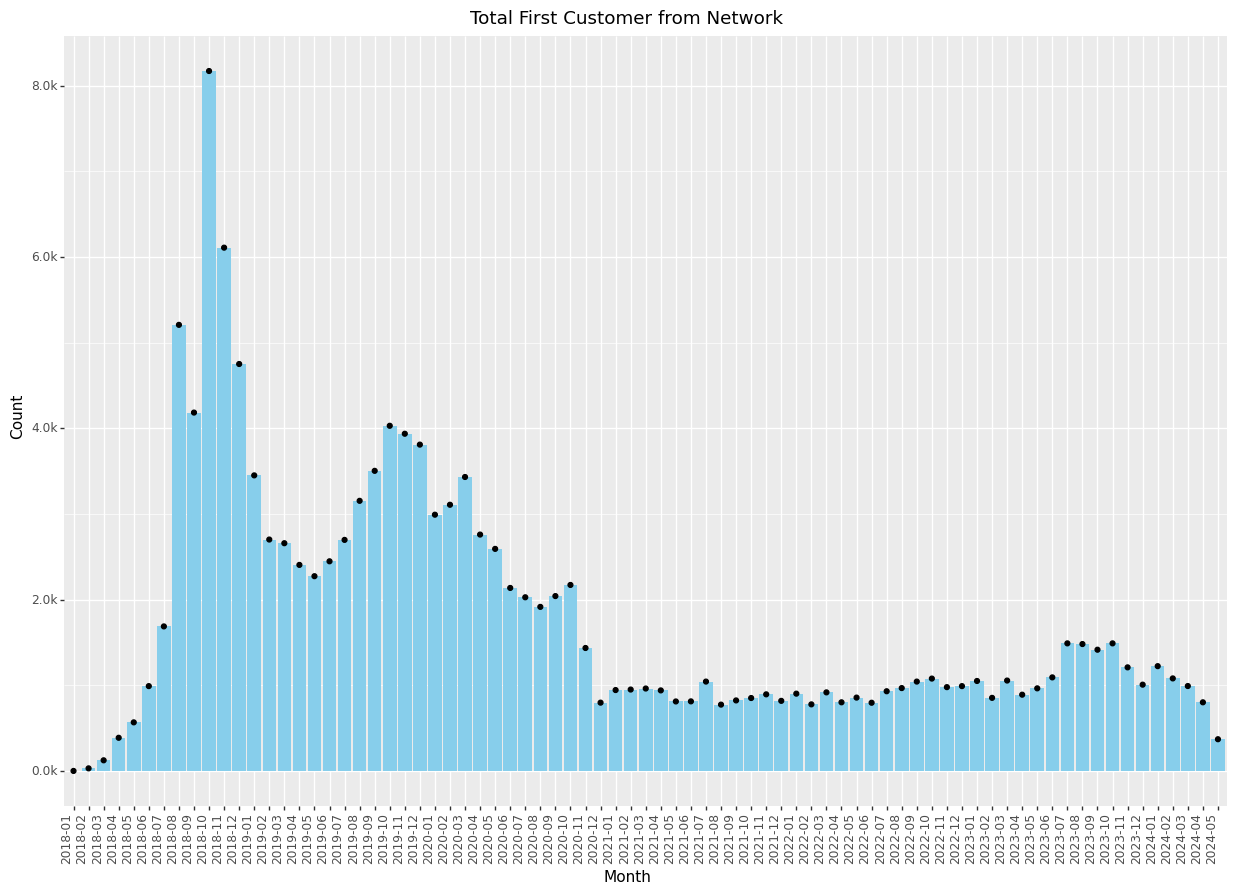

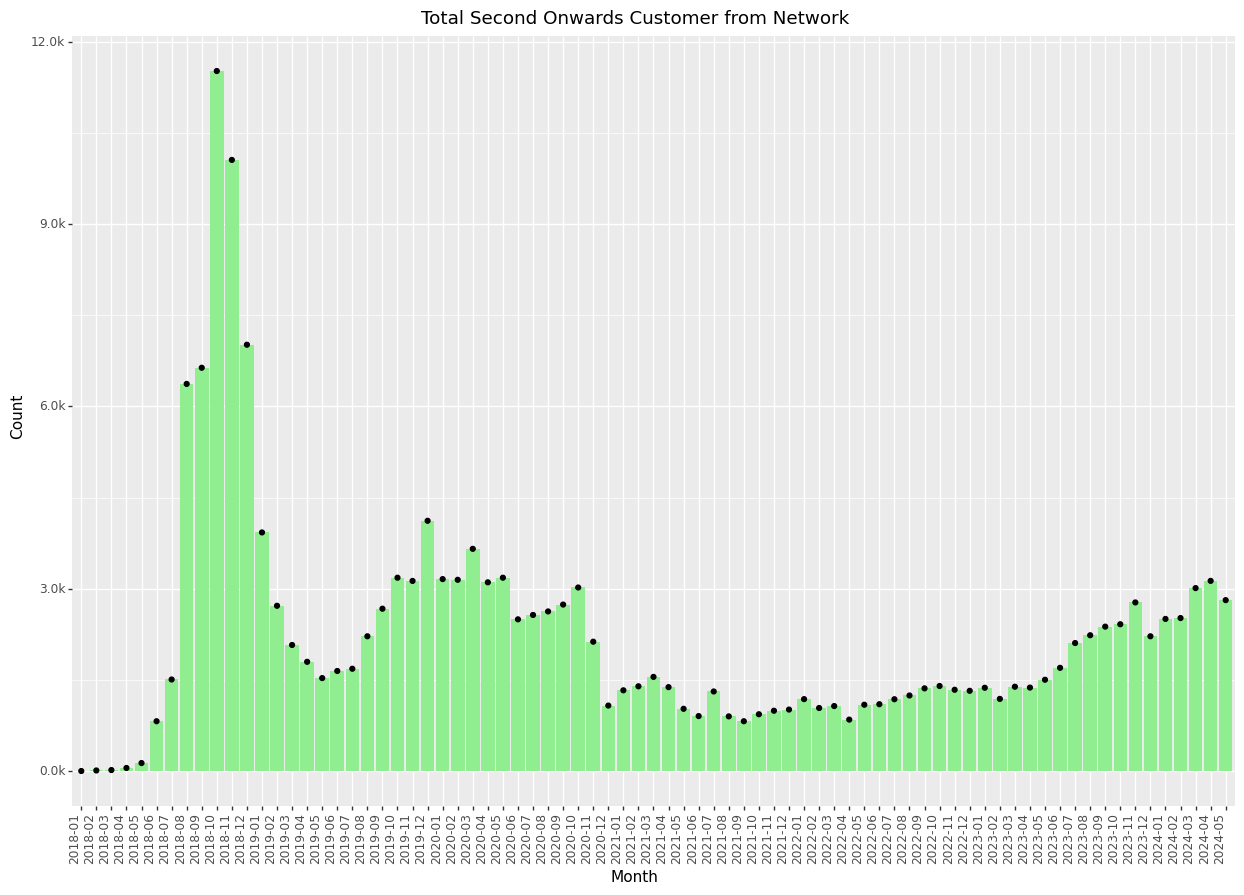

In [138]:
plot1 =     (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='nk_fc_total_customers')) +
    pn.geom_bar(stat='identity', fill="skyblue") +  # Changed from pn.geom_line() to pn.geom_bar(stat='identity')
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    # pn.facet_wrap('~order_country_code', scales="free_y", ncol=4) +
     pn.labs(x='Month', y='Count', title='Total First Customer from Network')+
    pn.theme(figure_size=(15, 10),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )
# Create the second plot
plot2 = (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='nk_sc_total_customers')) +
    pn.geom_bar(stat='identity', fill="lightgreen") +  # Changed from pn.geom_line() to pn.geom_bar(stat='identity')
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.labs(x='Month', y='Count', title='Total Second Onwards Customer from Network')+
    pn.theme(figure_size=(15, 10),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )

print(plot1)
print(plot2)

# Orders

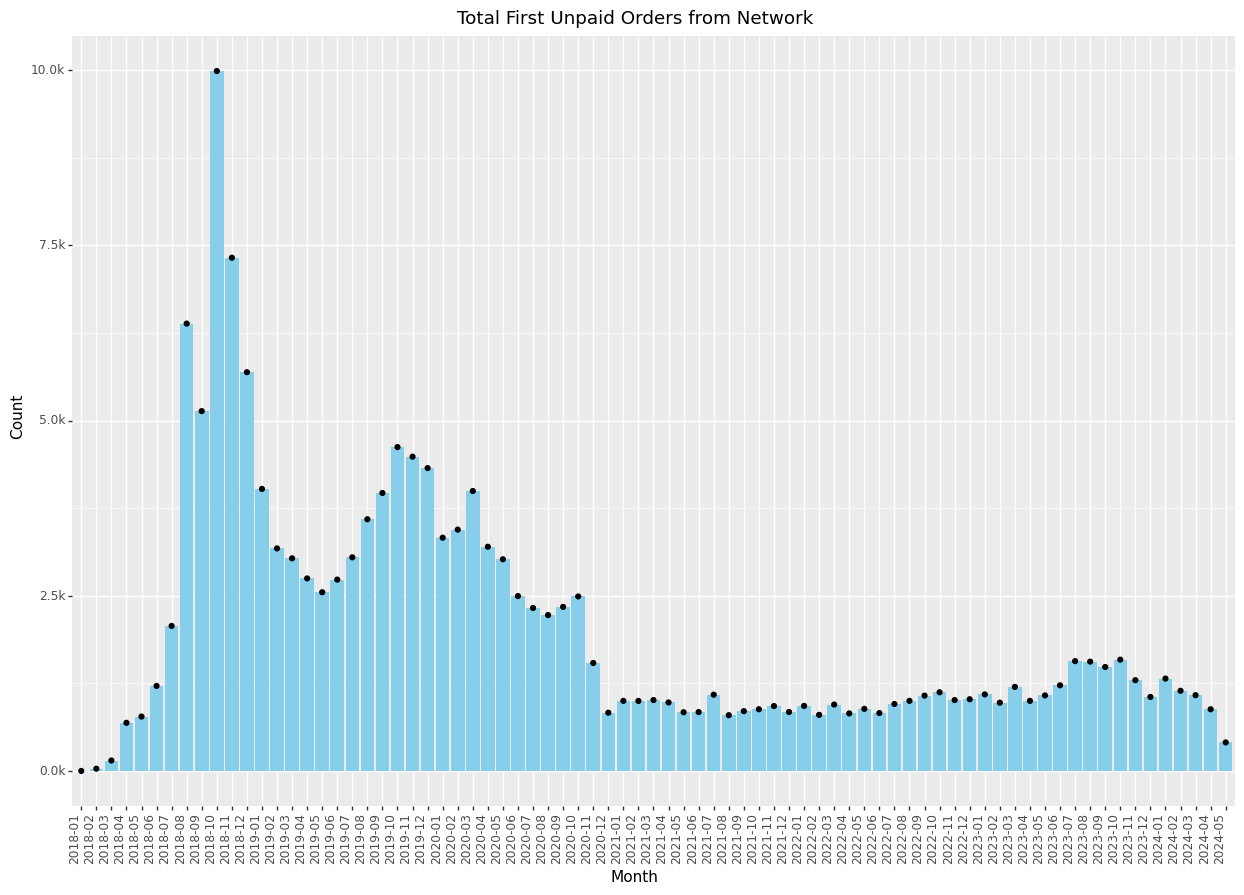

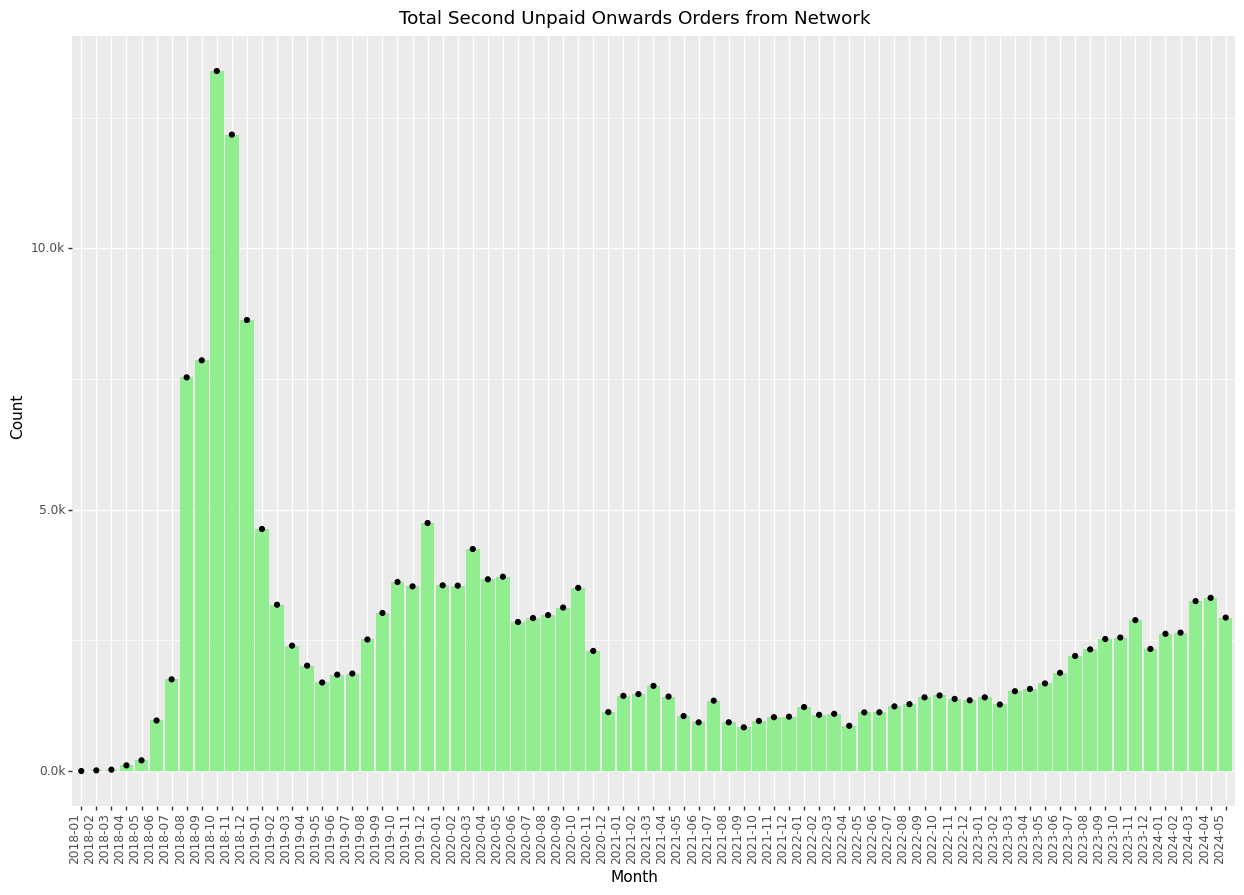

In [139]:
plot1 =     (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='nk_fc_total_orders')) +
    pn.geom_bar(stat='identity', fill="skyblue") +  # Changed from pn.geom_line() to pn.geom_bar(stat='identity')
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    # pn.facet_wrap('~order_country_code', scales="free_y", ncol=4) +
     pn.labs(x='Month', y='Count', title='Total First Unpaid Orders from Network')+
    pn.theme(figure_size=(15, 10),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )
# Create the second plot
plot2 = (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='nk_sc_total_orders')) +
    pn.geom_bar(stat='identity', fill="lightgreen") +  # Changed from pn.geom_line() to pn.geom_bar(stat='identity')
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.labs(x='Month', y='Count', title='Total Second Unpaid Onwards Orders from Network')+
    pn.theme(figure_size=(15, 10),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )

print(plot1)
print(plot2)

In [140]:
month_diff

order_date_month  nk_fc_total_customers  nk_sc_total_customers  \
0           2018-01                      1                      0   
1           2018-02                     31                      9   
2           2018-03                    125                     16   
3           2018-04                    388                     50   
4           2018-05                    568                    131   
..              ...                    ...                    ...   
72          2024-01                   1224                   2503   
73          2024-02                   1081                   2517   
74          2024-03                    992                   3010   
75          2024-04                    802                   3129   
76          2024-05                    371                   2812   

    nk_fc_total_orders  nk_sc_total_orders  nk_fc_total_gmv  nk_sc_total_gmv  
0                    1                   0         0.000000         0.000000  
1                   33                  12        95.272825        98.326440  
2                  150                  26        76.715785         0.000000  
3                  688                 108       277.403171       239.022651  
4                  777                 204       619.912350       440.094731  
..                 ...                 ...              ...              ...  
72                1319                2626     22903.197235     44525.487052  
73                1145                2648     19822.809907     49326.465757  
74                1082                3251     20198.683396     58571.255620  
75                 881                3314     19613.294862     59675.294761  
76                 408                2936      9702.830876     53824.479552  

[77 rows x 7 columns]

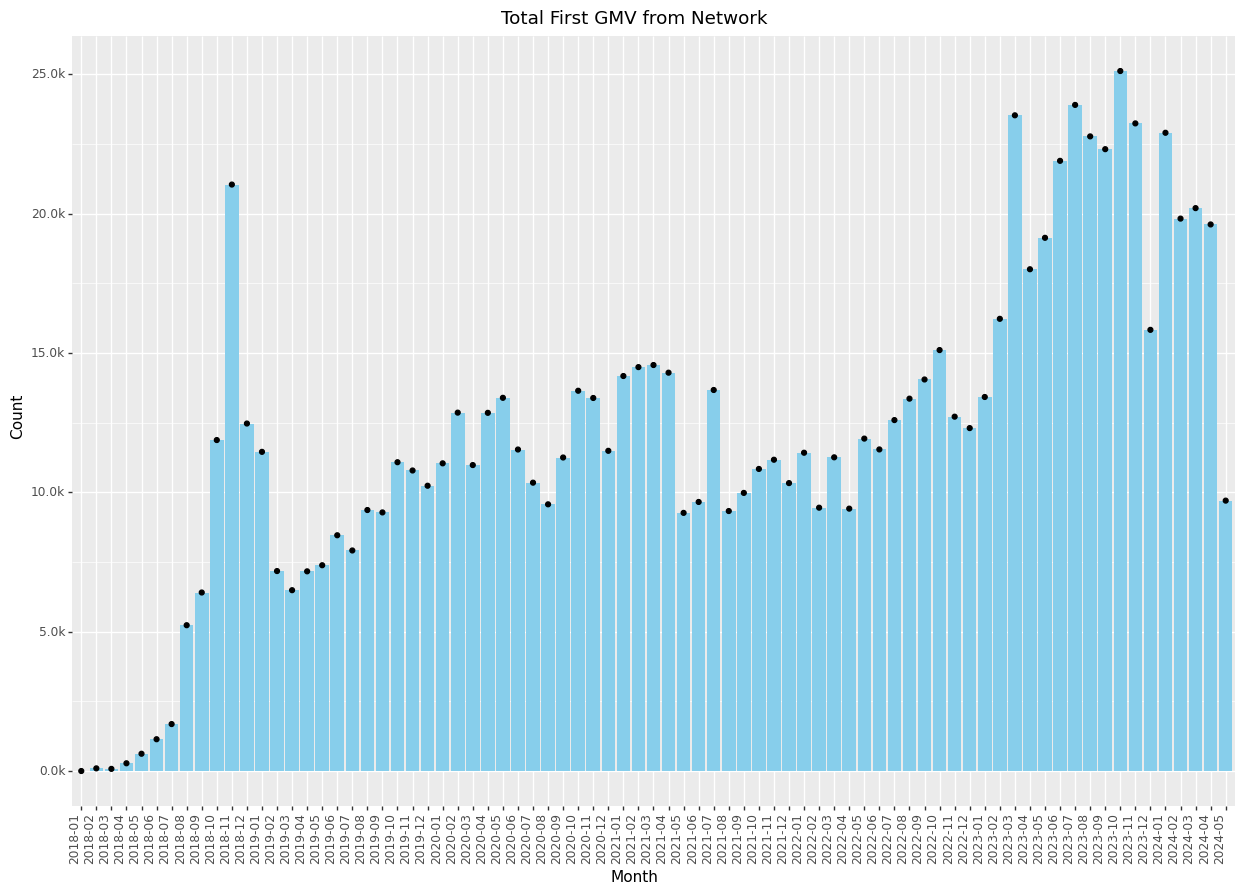

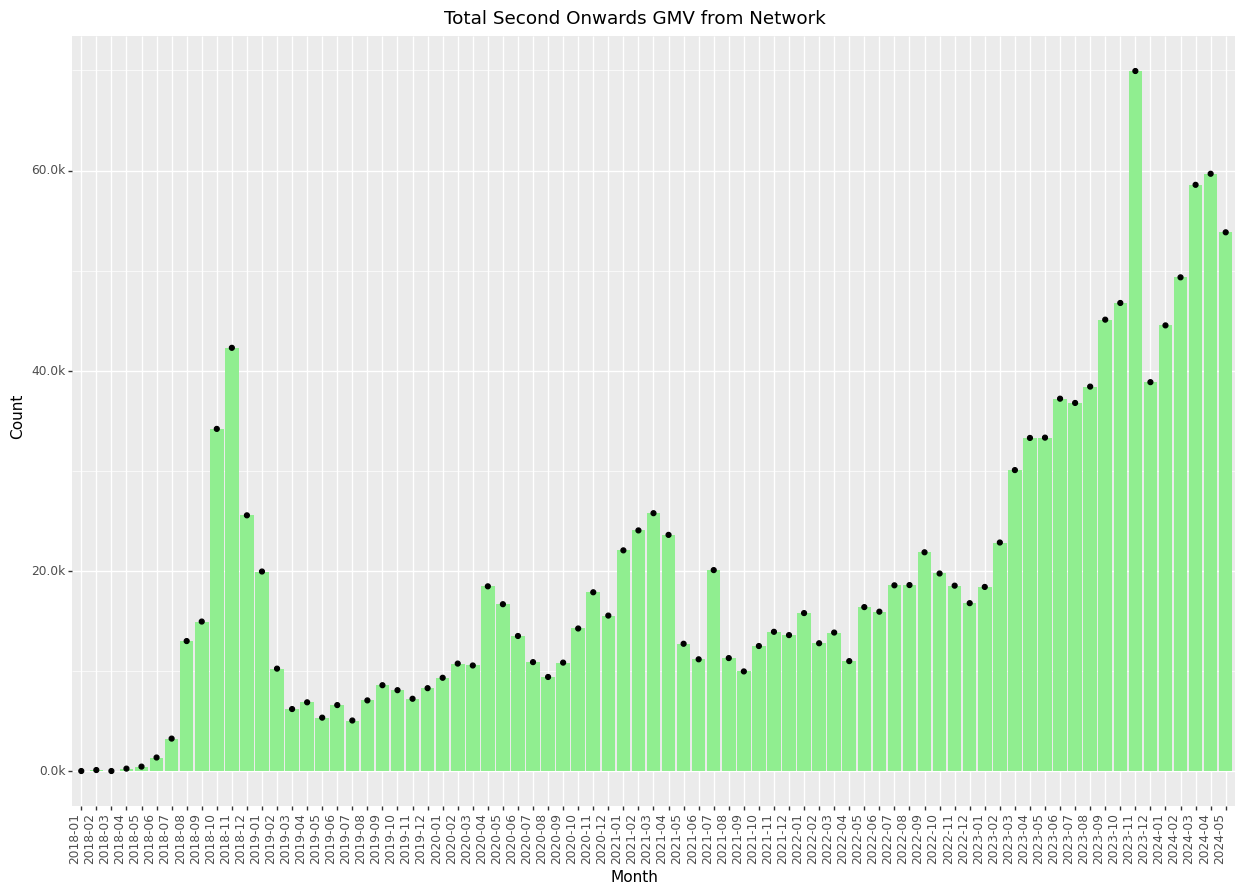

In [141]:
plot1 =     (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='nk_fc_total_gmv')) +
    pn.geom_bar(stat='identity', fill="skyblue") +  # Changed from pn.geom_line() to pn.geom_bar(stat='identity')
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    # pn.facet_wrap('~order_country_code', scales="free_y", ncol=4) +
     pn.labs(x='Month', y='Count', title='Total First GMV from Network')+
    pn.theme(figure_size=(15, 10),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )
# Create the second plot
plot2 = (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='nk_sc_total_gmv')) +
    pn.geom_bar(stat='identity', fill="lightgreen") +  # Changed from pn.geom_line() to pn.geom_bar(stat='identity')
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.labs(x='Month', y='Count', title='Total Second Onwards GMV from Network')+
    pn.theme(figure_size=(15, 10),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )

print(plot1)
print(plot2)

In [143]:
month_diff=df.groupby(
        ['order_date_month', 'order_country_code'],
        as_index=False
    ).agg(
        nk_fc_total_customers=('unique_frist_network_customer', 'sum'),    
        nk_sc_total_customers=('unique_second_onwards_network_customer', 'sum'),        
    
    
        nk_fc_total_orders=('unique_frist_network_orders', 'sum'),    
        nk_sc_total_orders=('unique_second_onwards_network_orders', 'sum'),
    
        nk_fc_total_gmv=('frist_network_unpaid_gmv', 'sum'),
        nk_sc_total_gmv=('second_onwards_network_unpaid_gmv', 'sum')
        # Add more columns as needed
    )

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


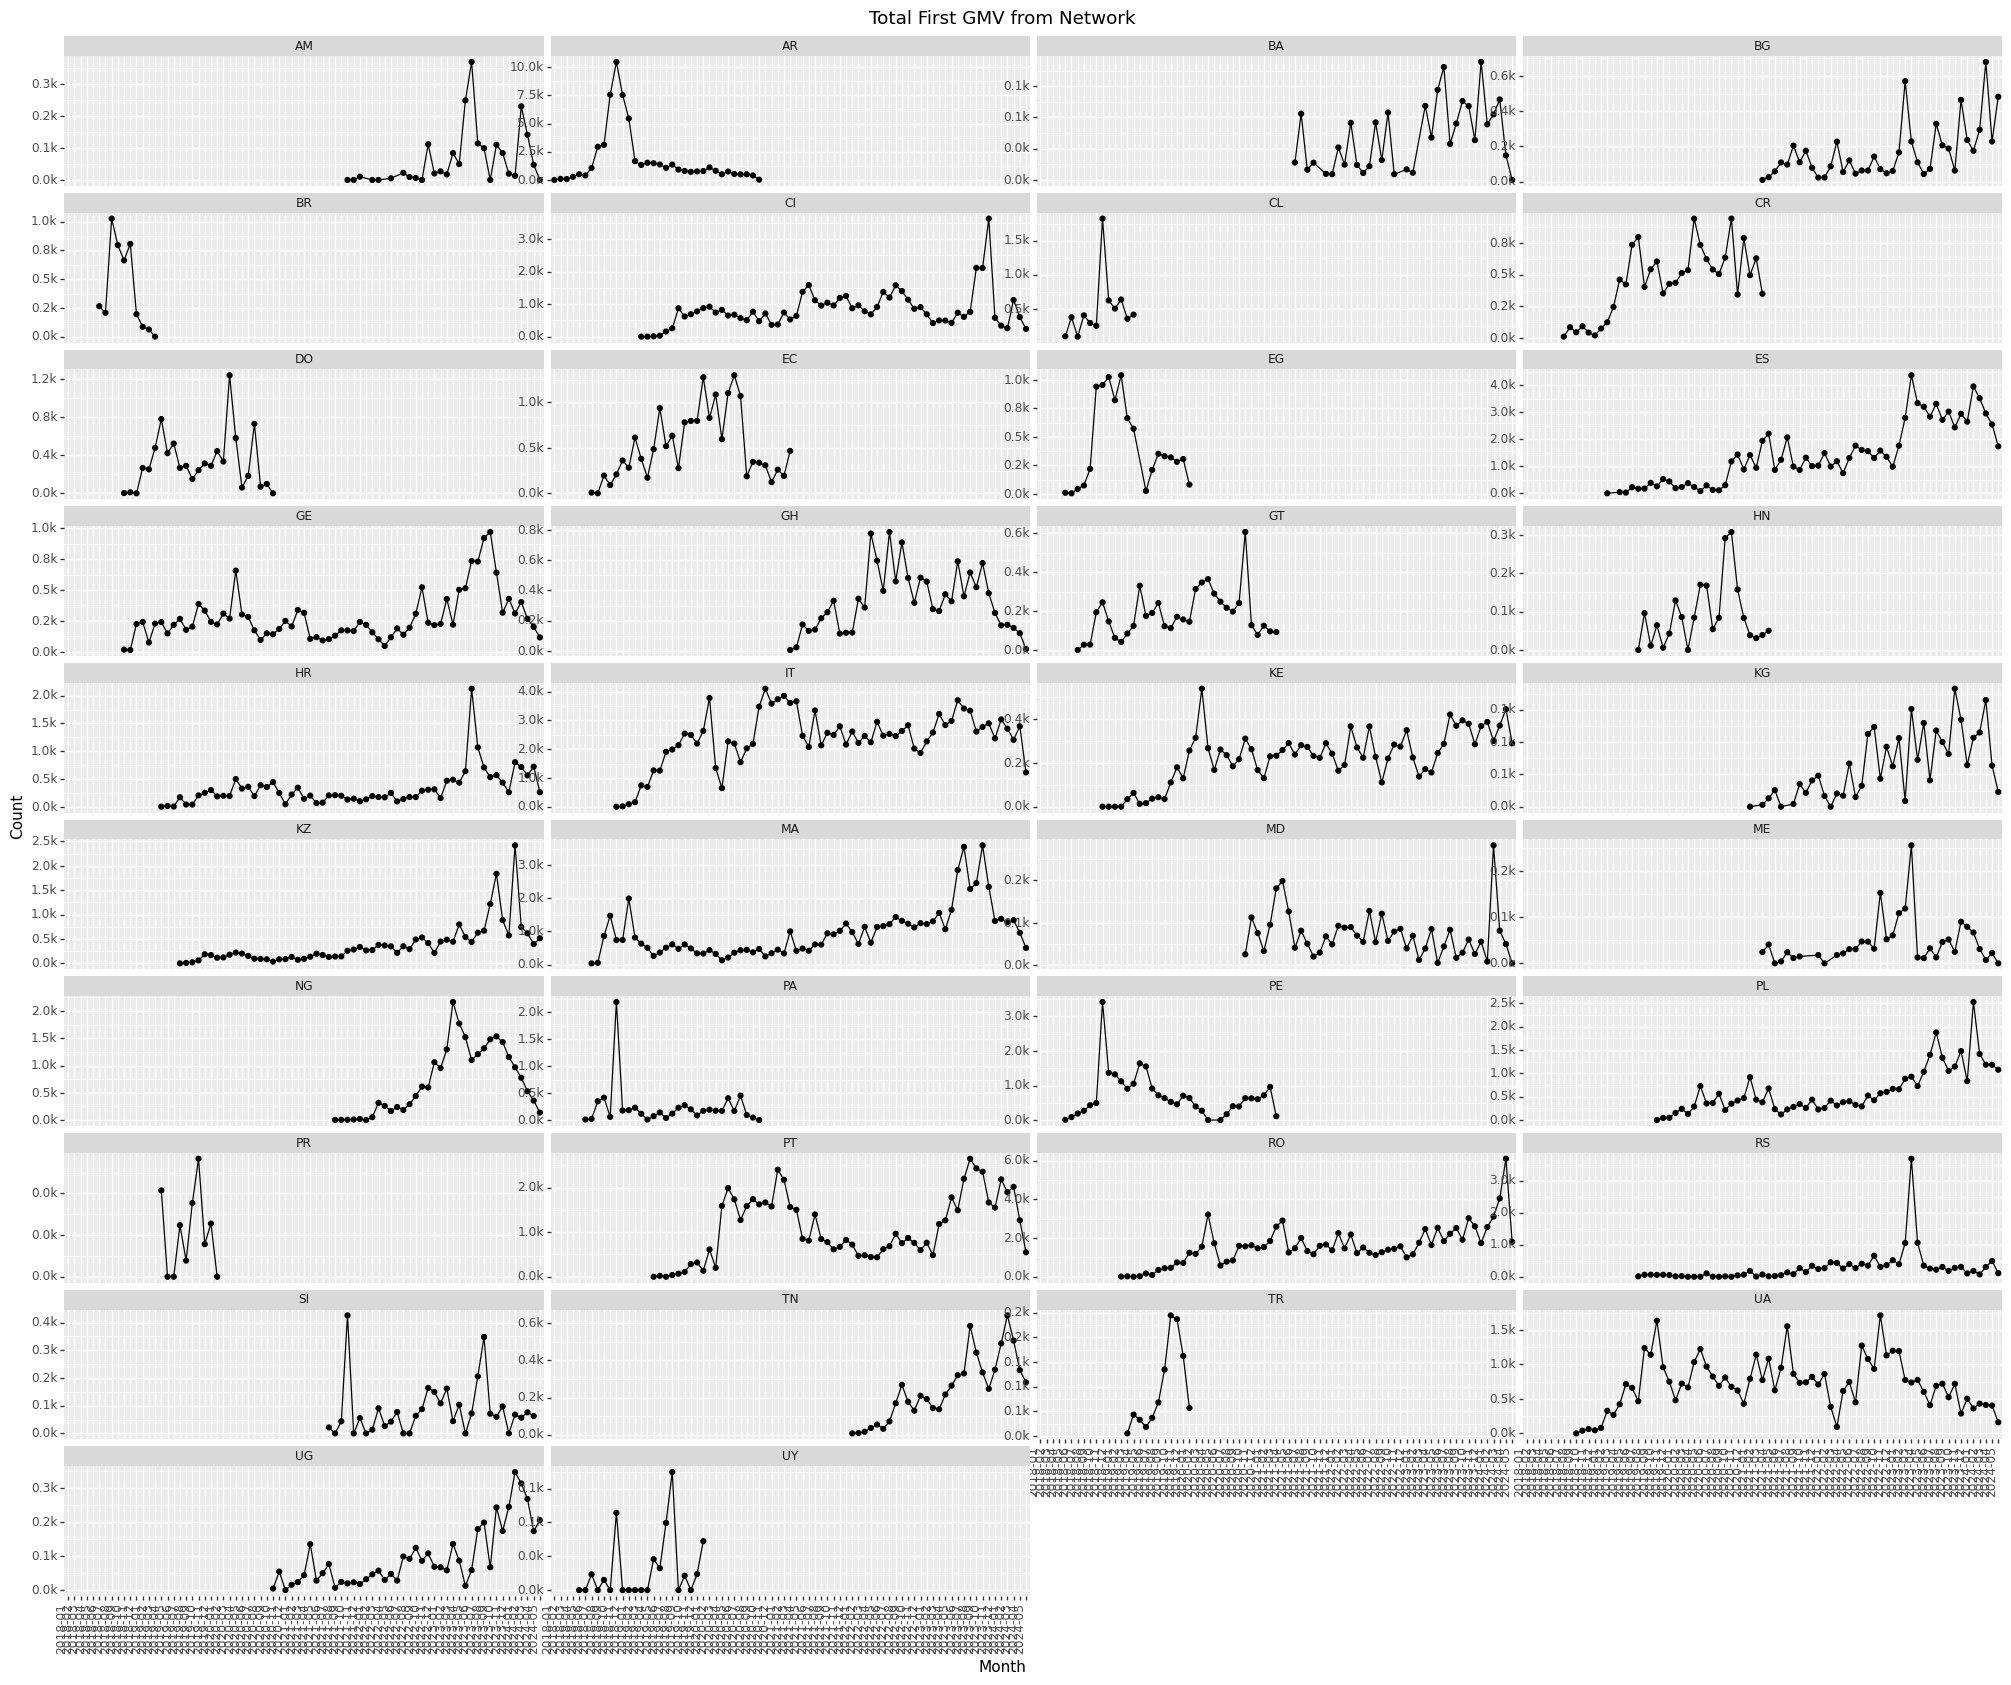

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


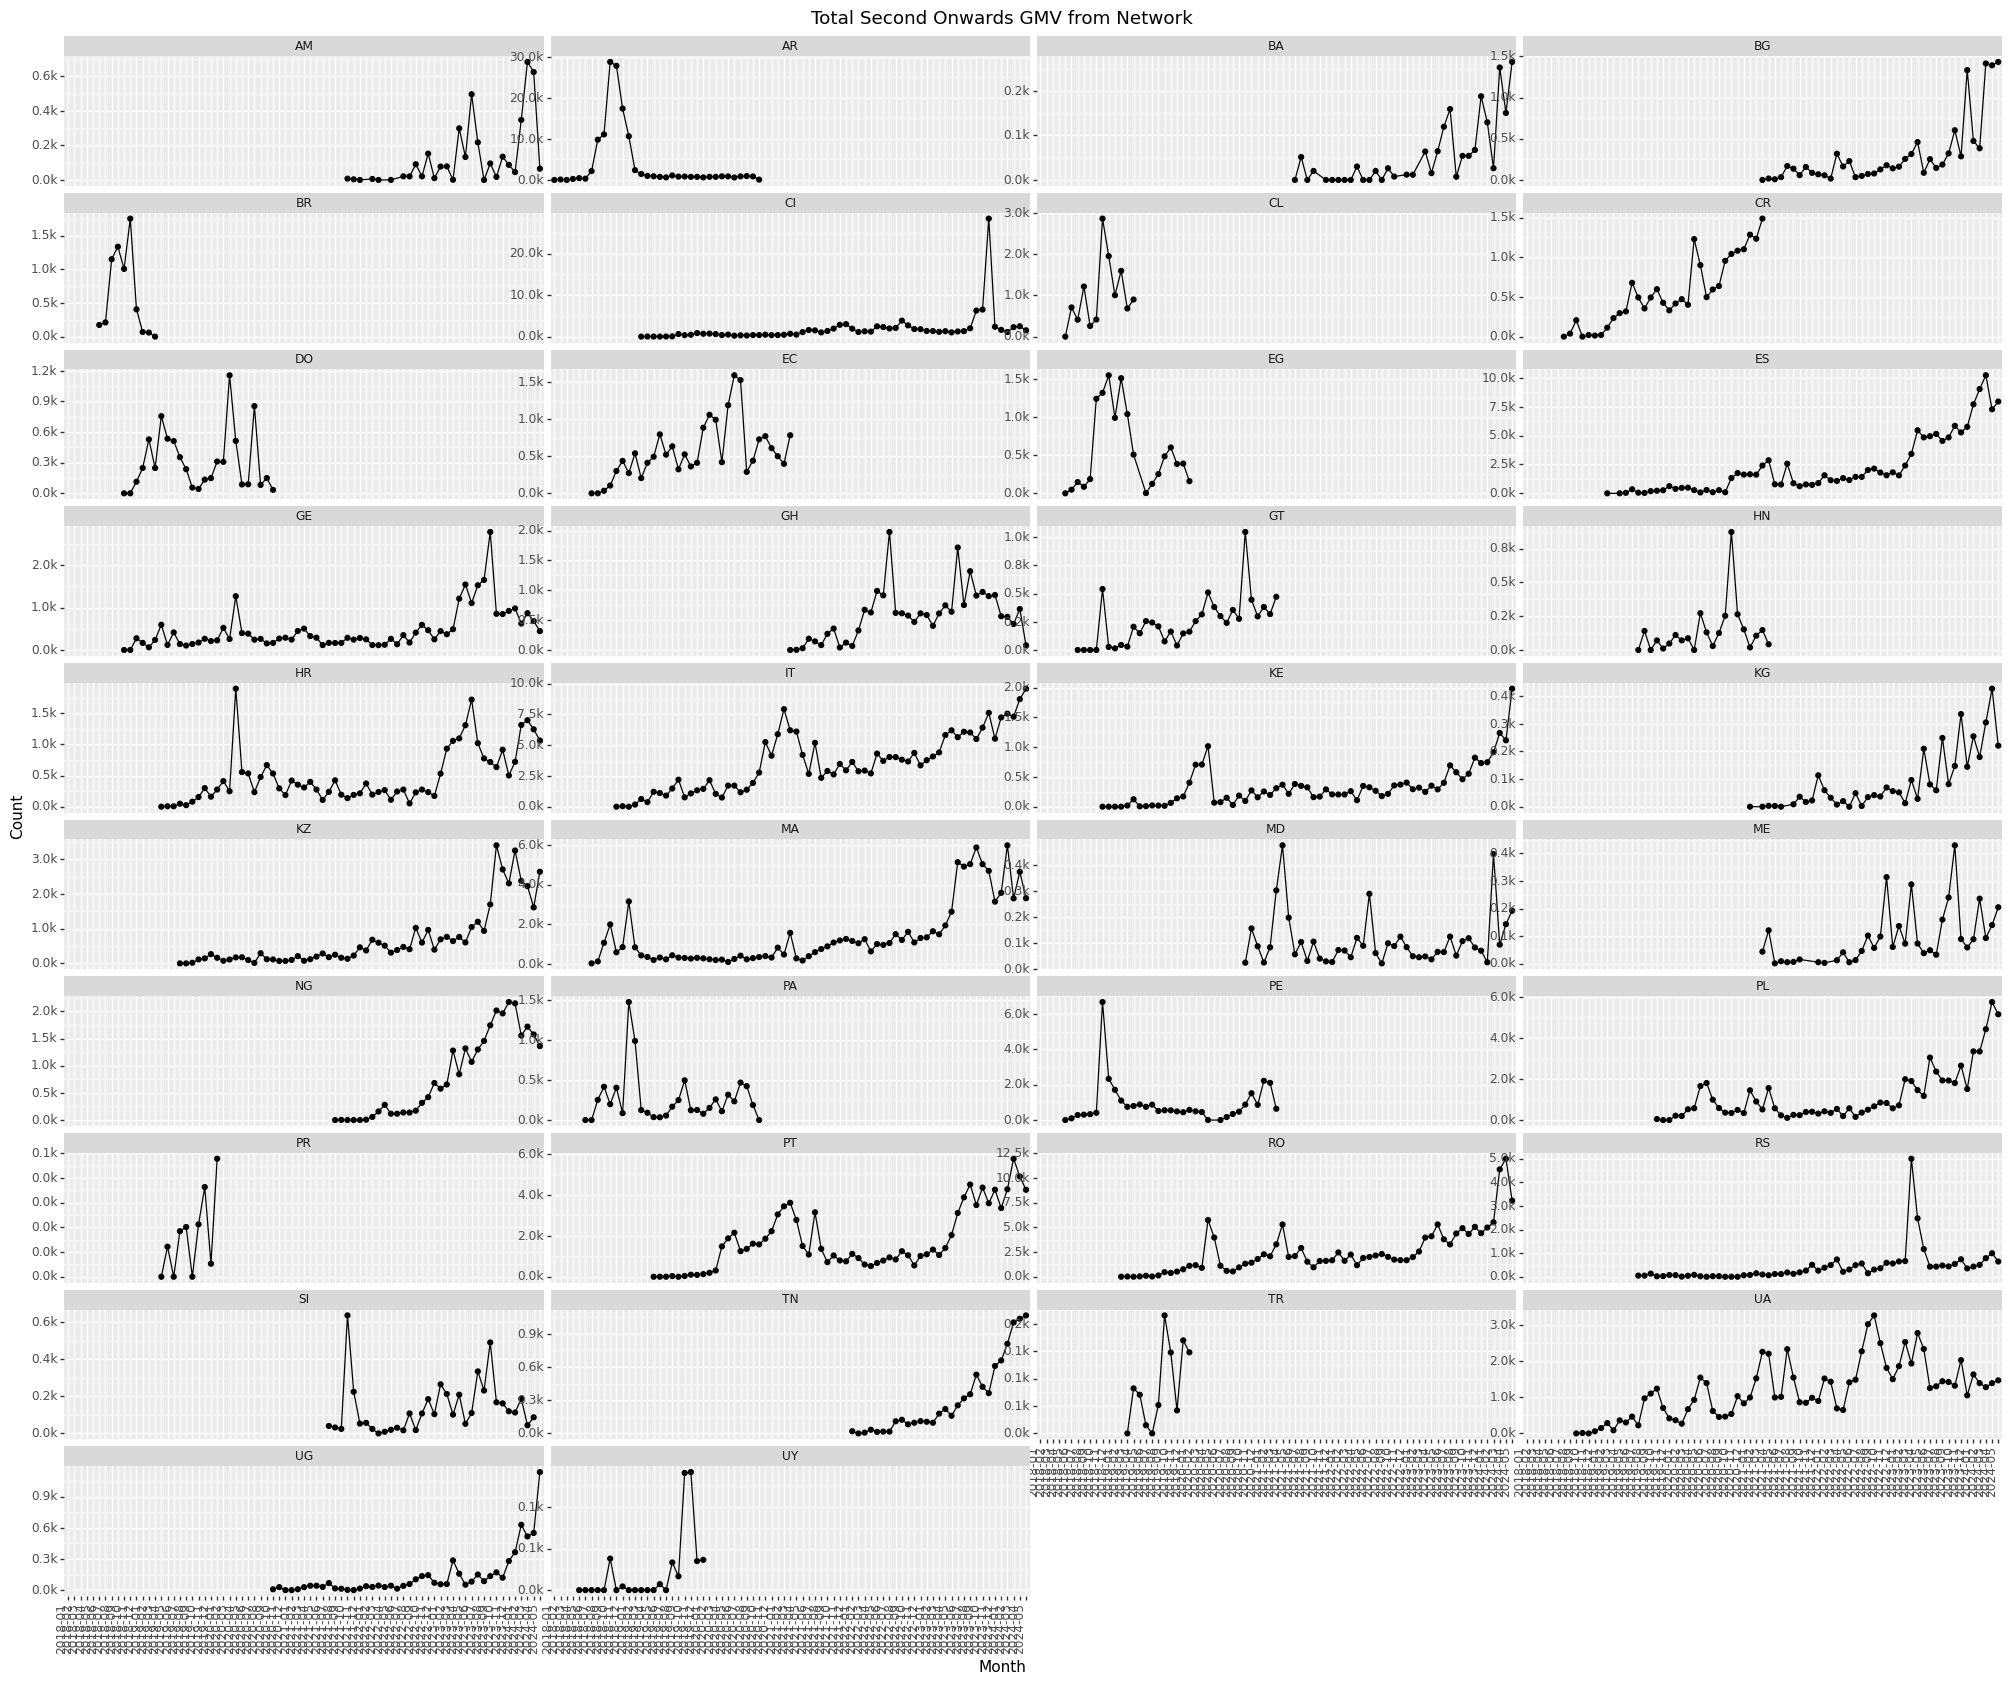

In [144]:
plot1 =     (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='nk_fc_total_gmv', group='order_country_code')) +
    pn.geom_line() +
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    # pn.facet_wrap('~order_country_code', scales="free_y", ncol=4) +
     pn.labs(x='Month', y='Count', title='Total First GMV from Network')+
     pn.facet_wrap('~order_country_code', scales="free_y", ncol=4) 
        +            
     pn.theme(figure_size=(25, 20),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )
# Create the second plot
plot2 = (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='nk_sc_total_gmv', group='order_country_code')) +
    pn.geom_line() +#pn.geom_bar(stat='identity', fill="lightgreen") +  # Changed from pn.geom_line() to pn.geom_bar(stat='identity')
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.labs(x='Month', y='Count', title='Total Second Onwards GMV from Network')+
    pn.facet_wrap('~order_country_code', scales="free_y", ncol=4) +            
    pn.theme(figure_size=(25, 20),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )

print(plot1)
print(plot2)

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 276 rows containing missing values.


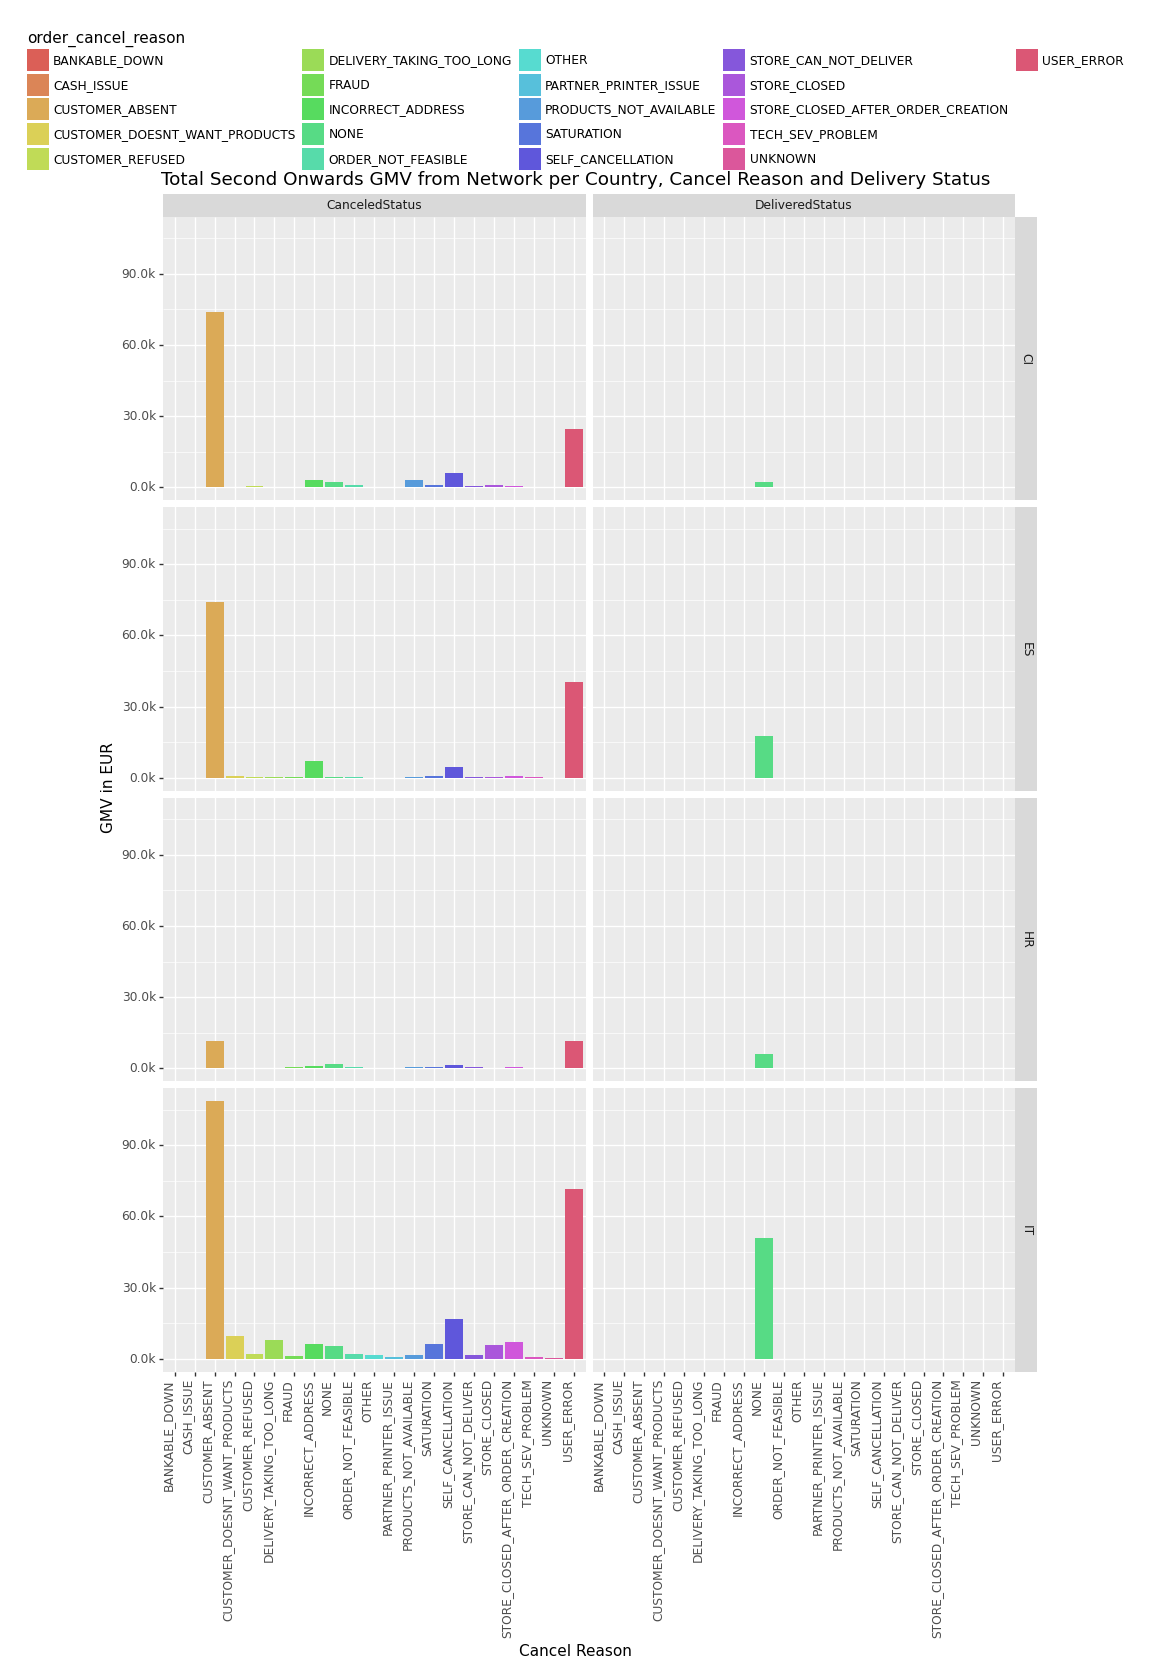

<ggplot: (681902013)>

In [145]:
(
    pn.ggplot(df.query('order_country_code in ["CI","ES","HR","IT"]')# "AM","BA","GE","KE","KG","KZ"
    , pn.aes(x='order_cancel_reason', y='second_onwards_network_unpaid_estimated_gmv', fill='order_cancel_reason')) +
    pn.geom_col() +
    pn.facet_grid('order_country_code~order_final_status') +
    pn.labs(x='Cancel Reason', y='GMV in EUR', title='Total Second Onwards GMV from Network per Country, Cancel Reason and Delivery Status')+
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(angle=90, hjust=1), legend_position='top', figure_size=(11,15))
)

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 329 rows containing missing values.


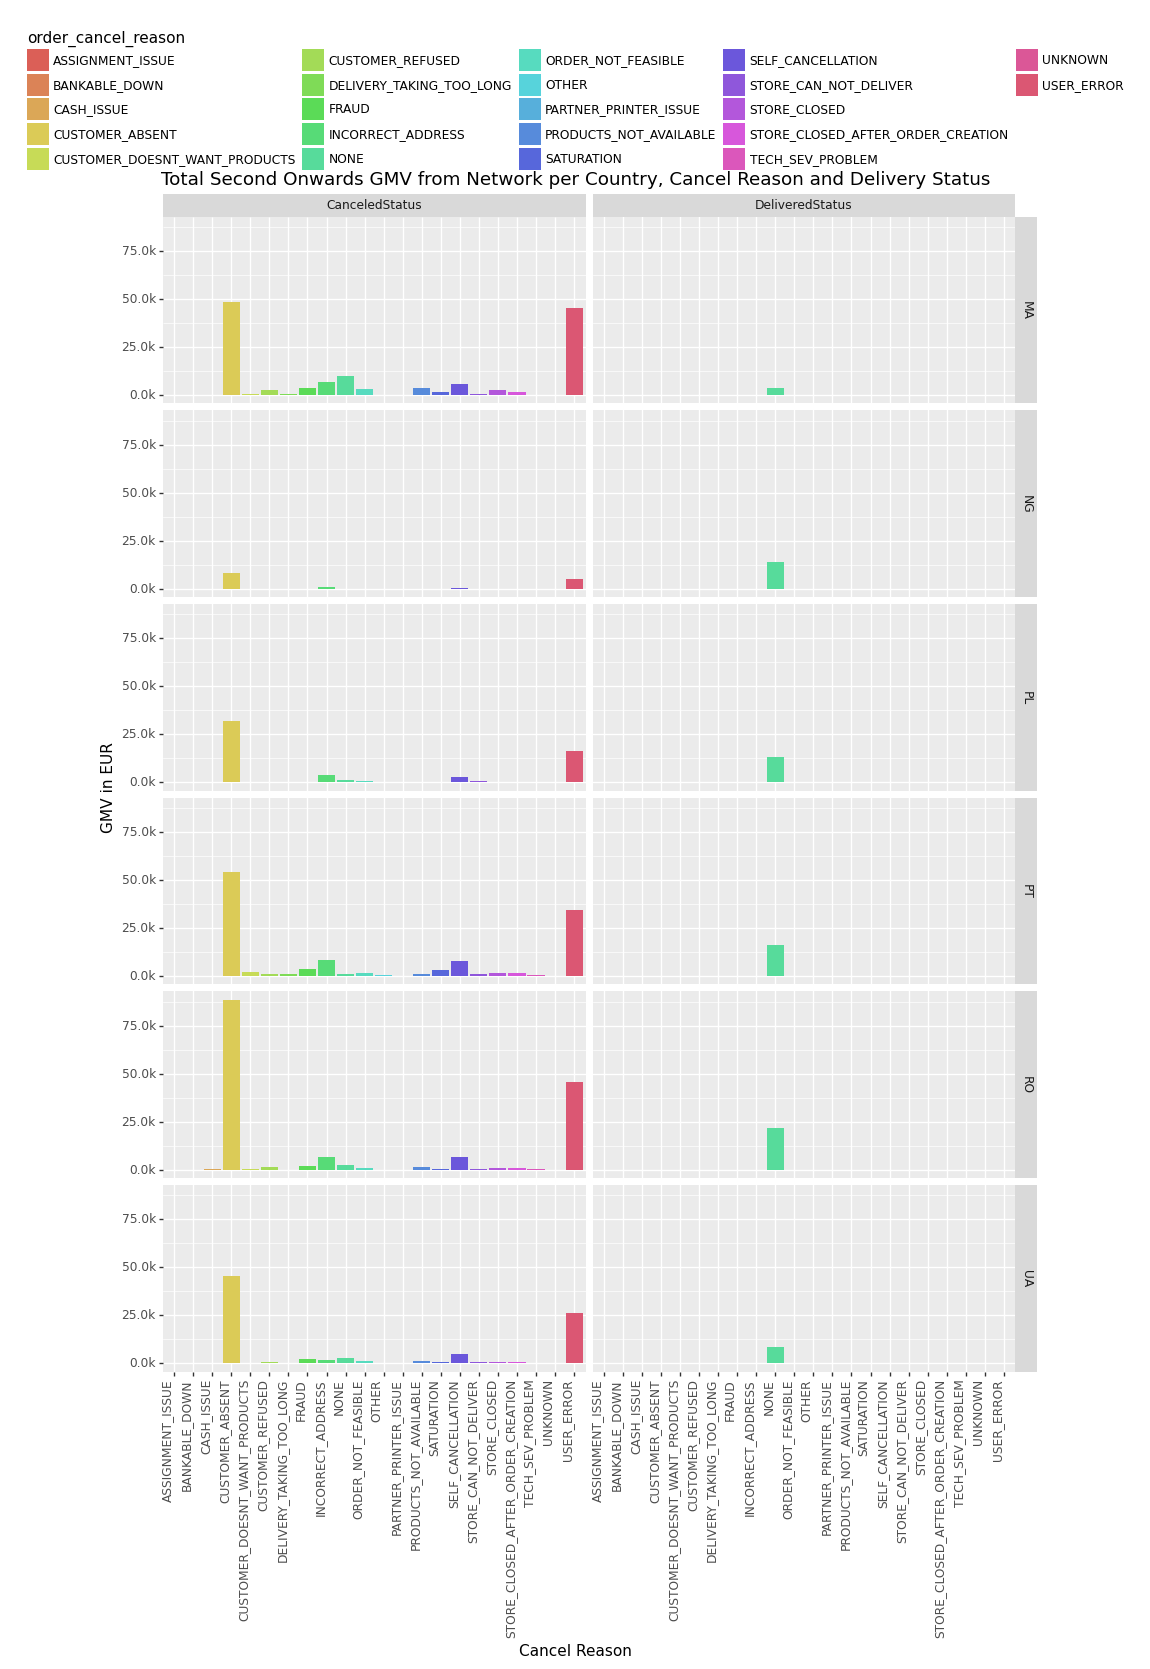

<ggplot: (683230129)>

In [146]:
(
    pn.ggplot(df.query('order_country_code in ["MA","NG","PL","PT","RO","UA"]')#,"MD","ME","TN","UG"
    , pn.aes(x='order_cancel_reason', y='second_onwards_network_unpaid_estimated_gmv', fill='order_cancel_reason')) +
    pn.geom_col() +
    pn.facet_grid('order_country_code~order_final_status') +
    pn.labs(x='Cancel Reason', y='GMV in EUR', title='Total Second Onwards GMV from Network per Country, Cancel Reason and Delivery Status')+
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(angle=90, hjust=1), legend_position='top', figure_size=(11,15))
)

# PAID in UNPAID NETWORKS 

In [2]:
## Starbust credentials (this works alone, no need to modify)
HOST = 'starburst.g8s-data-platform-prod.glovoint.com'
PORT = 443


conn_details = {
    'host': HOST,
    'port': PORT,
    'http_scheme': 'https',
    'auth': trino.auth.OAuth2Authentication()
}

In [410]:
query2='''


WITH cash_unpaid_network AS (

SELECT *, row_number() over (PARTITION BY device_id   order by first_order_date asc) as first_network_user_count -- Understand the network count
        , row_number() over (PARTITION BY device_id   order by first_order_date desc) as last_network_number_count -- how big the network is connected to the device
FROM(SELECT  MIN(o.order_created_at) AS first_order_date, o.device_id, o.customer_id FROM delta.central_order_descriptors_odp.order_descriptors_v2 o LEFT JOIN delta.fintech_payments_odp.payments p ON p.order_id = o.order_id WHERE TRUE AND  p.payment_status='NOT_PAID' AND p.payment_method='CASH' AND -- WITH THE FILTER OF BELOW i GET THE DEVICE CASH UNPAID NETWORKS, MEANING NETWORKS WITH 2 OR MORE CUSTOMERS SHARING DEVICE WITH CASH UNPAID EACH
                        o.device_id IN (SELECT DISTINCT o.device_id  FROM delta.central_order_descriptors_odp.order_descriptors_v2 o LEFT JOIN delta.fintech_payments_odp.payments p ON p.order_id = o.order_id GROUP BY o.device_id HAVING COUNT(DISTINCT CASE WHEN p.payment_status='NOT_PAID' AND p.payment_method='CASH' THEN o.customer_id ELSE NULL END) > 1) GROUP BY 2,3) -- Con esto tengo networks de unpaid que tienen más de 1 user
)       

, ADDED AS (
SELECT 
        -- order 
        cn.first_order_date
        , cn.device_id
        , cn.customer_id
        , cn.first_network_user_count -- Understand the network count
        , cn.last_network_number_count -- how big the network is connected to the device
       , row_number() over (PARTITION BY o.order_id  order by o.order_created_at asc) as first_order_id -- security_check
       , o.order_created_at
       , o.order_country_code
       , o.order_id
        , o.order_final_status
        , o.order_cancel_reason
        , o.order_total_purchase_eur
        , o.order_estimated_purchase_eur
        -- payment
        , p.payment_status
        , p.payment_method
        -- cm
        , cm.gmvalu_eur AS GMV_cm_table
        , cm.contribution_margin_eur 
FROM  cash_unpaid_network cn 
        LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2 o ON o.device_id = cn.device_id AND o.customer_id = cn.customer_id
        LEFT JOIN delta.fintech_payments_odp.payments p                      ON p.order_id  = o.order_id
        LEFT JOIN delta.finance_financial_reports_odp.pnl_order_level cm     ON cm.order_id=o.order_id         
WHERE TRUE-- AND  p.payment_status='NOT_PAID' AND p.payment_method='CASH' 
)


SELECT DATE(DATE_TRUNC('month', order_created_at)) AS date
       , order_country_code
       , order_final_status
       , order_cancel_reason
       , payment_status
       , payment_method
       , COUNT(DISTINCT device_id) AS total_devices
       , COUNT(DISTINCT customer_id) AS total_customers
       , COUNT(DISTINCT order_id) AS total_orders

       --, COUNT(DISTINCT CASE WHEN first_network_user_count=1 THEN customer_id ELSE NULL END) AS unique_frist_network_customer
       --, COUNT(DISTINCT CASE WHEN first_network_user_count>1 THEN customer_id ELSE NULL END) AS unique_second_onwards_network_customer

       --, COUNT(DISTINCT CASE WHEN first_network_user_count=1 THEN order_id ELSE NULL END) AS unique_frist_network_orders
       --, COUNT(DISTINCT CASE WHEN first_network_user_count>1 THEN order_id ELSE NULL END) AS unique_second_onwards_network_orders
       
       , COUNT(DISTINCT CASE WHEN first_order_id=1 AND order_total_purchase_eur=0 THEN order_id ELSE NULL END) AS cero_order_gmv
       , COUNT(DISTINCT CASE WHEN first_order_id=1 AND order_total_purchase_eur>0 THEN order_id ELSE NULL END) AS more_than_cero_order_gmv


       , SUM(CASE WHEN first_order_id=1 THEN order_total_purchase_eur ELSE NULL END) AS gmv
       , SUM(CASE WHEN first_order_id=1 THEN contribution_margin_eur ELSE NULL END) AS cm
       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count=1 THEN order_total_purchase_eur ELSE NULL END) AS frist_network_gmv
       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count=1 THEN order_estimated_purchase_eur ELSE NULL END) AS frist_network_estimated_gmv
       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count=1 THEN contribution_margin_eur ELSE NULL END) AS frist_network_estimated_cm
       
       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count>1 THEN order_total_purchase_eur ELSE NULL END) AS second_onwards_network_gmv
       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count>1 THEN order_estimated_purchase_eur ELSE NULL END) AS second_onwards_network_estimated_gmv
       , SUM(CASE WHEN first_order_id=1 AND first_network_user_count>1 THEN contribution_margin_eur ELSE NULL END) AS second_onwards_network_cm

FROM ADDED
    GROUP BY 1,2,3,4,5,6 

'''

In [411]:
# To export result to pandas
with trino.dbapi.connect(**conn_details) as conn:
    df2 = pd.read_sql_query(query2, conn)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_47978/2668262966.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [412]:
df2

date order_country_code order_final_status  \
0      2019-02-01                 MA    DeliveredStatus   
1      2022-04-01                 GH    DeliveredStatus   
2      2019-06-01                 CR     CanceledStatus   
3      2020-11-01                 RS     CanceledStatus   
4      2020-11-01                 IT     CanceledStatus   
...           ...                ...                ...   
39624  2020-09-01                 KE     CanceledStatus   
39625  2022-01-01                 IT     CanceledStatus   
39626  2022-05-01                 UA     CanceledStatus   
39627  2019-03-01                 AR     CanceledStatus   
39628  2019-12-01                 TR     CanceledStatus   

                 order_cancel_reason payment_status payment_method  \
0                               None           PAID           CASH   
1                               None           PAID           CASH   
2                         USER_ERROR       NOT_PAID           CASH   
3                         USER_ERROR           PAID    CREDIT_CARD   
4                  INCORRECT_ADDRESS       NOT_PAID           CASH   
...                              ...            ...            ...   
39624         PRODUCTS_NOT_AVAILABLE           PAID           CASH   
39625                     USER_ERROR           PAID         PAYPAL   
39626                   STORE_CLOSED           PAID      APPLE_PAY   
39627          STORE_CAN_NOT_DELIVER       NOT_PAID           CASH   
39628  CUSTOMER_DOESNT_WANT_PRODUCTS       NOT_PAID           CASH   

       total_devices  total_customers  total_orders  cero_order_gmv  \
0                590              634          2333              37   
1                292              317          1316               7   
2                 33               38            41              25   
3                  2                2             2               1   
4                 25               25            26               0   
...              ...              ...           ...             ...   
39624              3                3             3               3   
39625              3                3             3               3   
39626              1                1             1               1   
39627             54               55            58              58   
39628             18               18            24              24   

       more_than_cero_order_gmv           gmv          cm  frist_network_gmv  \
0                          2296  17109.849746  194.524823       10331.873838   
1                          1309   7620.217747  340.625993        4999.035652   
2                            16    275.773880   33.181470         198.623800   
3                             1     21.177450    2.636905          21.177450   
4                            26    508.000000   50.762136         188.200000   
...                         ...           ...         ...                ...   
39624                         0      0.000000   -1.741368           0.000000   
39625                         0      0.000000   -2.231095           0.000000   
39626                         0      0.000000   -1.088771           0.000000   
39627                         0      0.000000    0.000000           0.000000   
39628                         0      0.000000    0.000000           0.000000   

       frist_network_estimated_gmv  frist_network_estimated_cm  \
0                      8873.159194                  101.644451   
1                      5028.267501                  179.294440   
2                       163.920000                   20.607170   
3                        21.177450                    3.061146   
4                       182.300000                   26.203306   
...                            ...                         ...   
39624                     0.000000                   -1.160912   
39625                    27.530000                   -1.655689   
39626                     8.789580                   -1

In [417]:
# import, getting date
df2.date.dtypes
df2.date=pd.to_datetime(df2.date)
df2['order_date']=df2['date'].dt.date
df2['order_date_week']=df2['date'].dt.to_period('W-SUN').dt.start_time
df2['order_date_month'] = df2['date'].dt.to_period('M')

# Exploratory Data Analysis

In [307]:
df2.duplicated().sum()

0

In [308]:
len(df2)

39629

In [309]:
missing_values_count = df2.isna().sum()

# Convert the Series to a DataFrame
missing_values_df2 = missing_values_count.reset_index()
missing_values_df2.columns = ['Column', 'MissingValues']

# Calculate the total length of the DataFrame
#total_length = len(df)

missing_values_df2['Total'] = len(df2)
# Calculate the proportion of missing values
missing_values_df2['Proportion'] = missing_values_df2['MissingValues'] /missing_values_df2['Total'] #total_length

In [310]:
missing_values_df2

Column  MissingValues  Total  Proportion
0                       date              0  39629    0.000000
1         order_country_code              0  39629    0.000000
2         order_final_status              0  39629    0.000000
3        order_cancel_reason           6552  39629    0.165333
4             payment_status              7  39629    0.000177
5             payment_method              7  39629    0.000177
6              total_devices              0  39629    0.000000
7            total_customers              0  39629    0.000000
8               total_orders              0  39629    0.000000
9             cero_order_gmv              0  39629    0.000000
10  more_than_cero_order_gmv              0  39629    0.000000
11                       gmv             11  39629    0.000278
12                        cm              5  39629    0.000126
13                order_date              0  39629    0.000000
14           order_date_week              0  39629    0.000000
15          order_date_month              0  39629    0.000000

In [311]:
df2.dtypes

date                        datetime64[ns]
order_country_code                  object
order_final_status                  object
order_cancel_reason                 object
payment_status                      object
payment_method                      object
total_devices                        int64
total_customers                      int64
total_orders                         int64
cero_order_gmv                       int64
more_than_cero_order_gmv             int64
gmv                                float64
cm                                 float64
order_date                          object
order_date_week             datetime64[ns]
order_date_month                 period[M]
dtype: object

In [312]:
df2.order_cancel_reason.fillna('NONE', inplace=True)

In [ ]:
#order_cancel_reason

In [314]:
month_diff=df2.groupby(
        ['order_date_month', 'order_country_code'],
        as_index=False
    ).agg(
        total_devices=('total_devices', 'sum'),    
        total_customers=('total_customers', 'sum'),        
    
    
        total_orders=('total_orders', 'sum'),    
        cero_order_gmv=('cero_order_gmv', 'sum'),
    
        more_than_cero_order_gmv=('more_than_cero_order_gmv', 'sum'),
        gmv=('gmv', 'sum'),
        cm=('cm', 'sum')
        # Add more columns as needed
    )

In [315]:
month_diff.total_customers.sum()

1210655

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


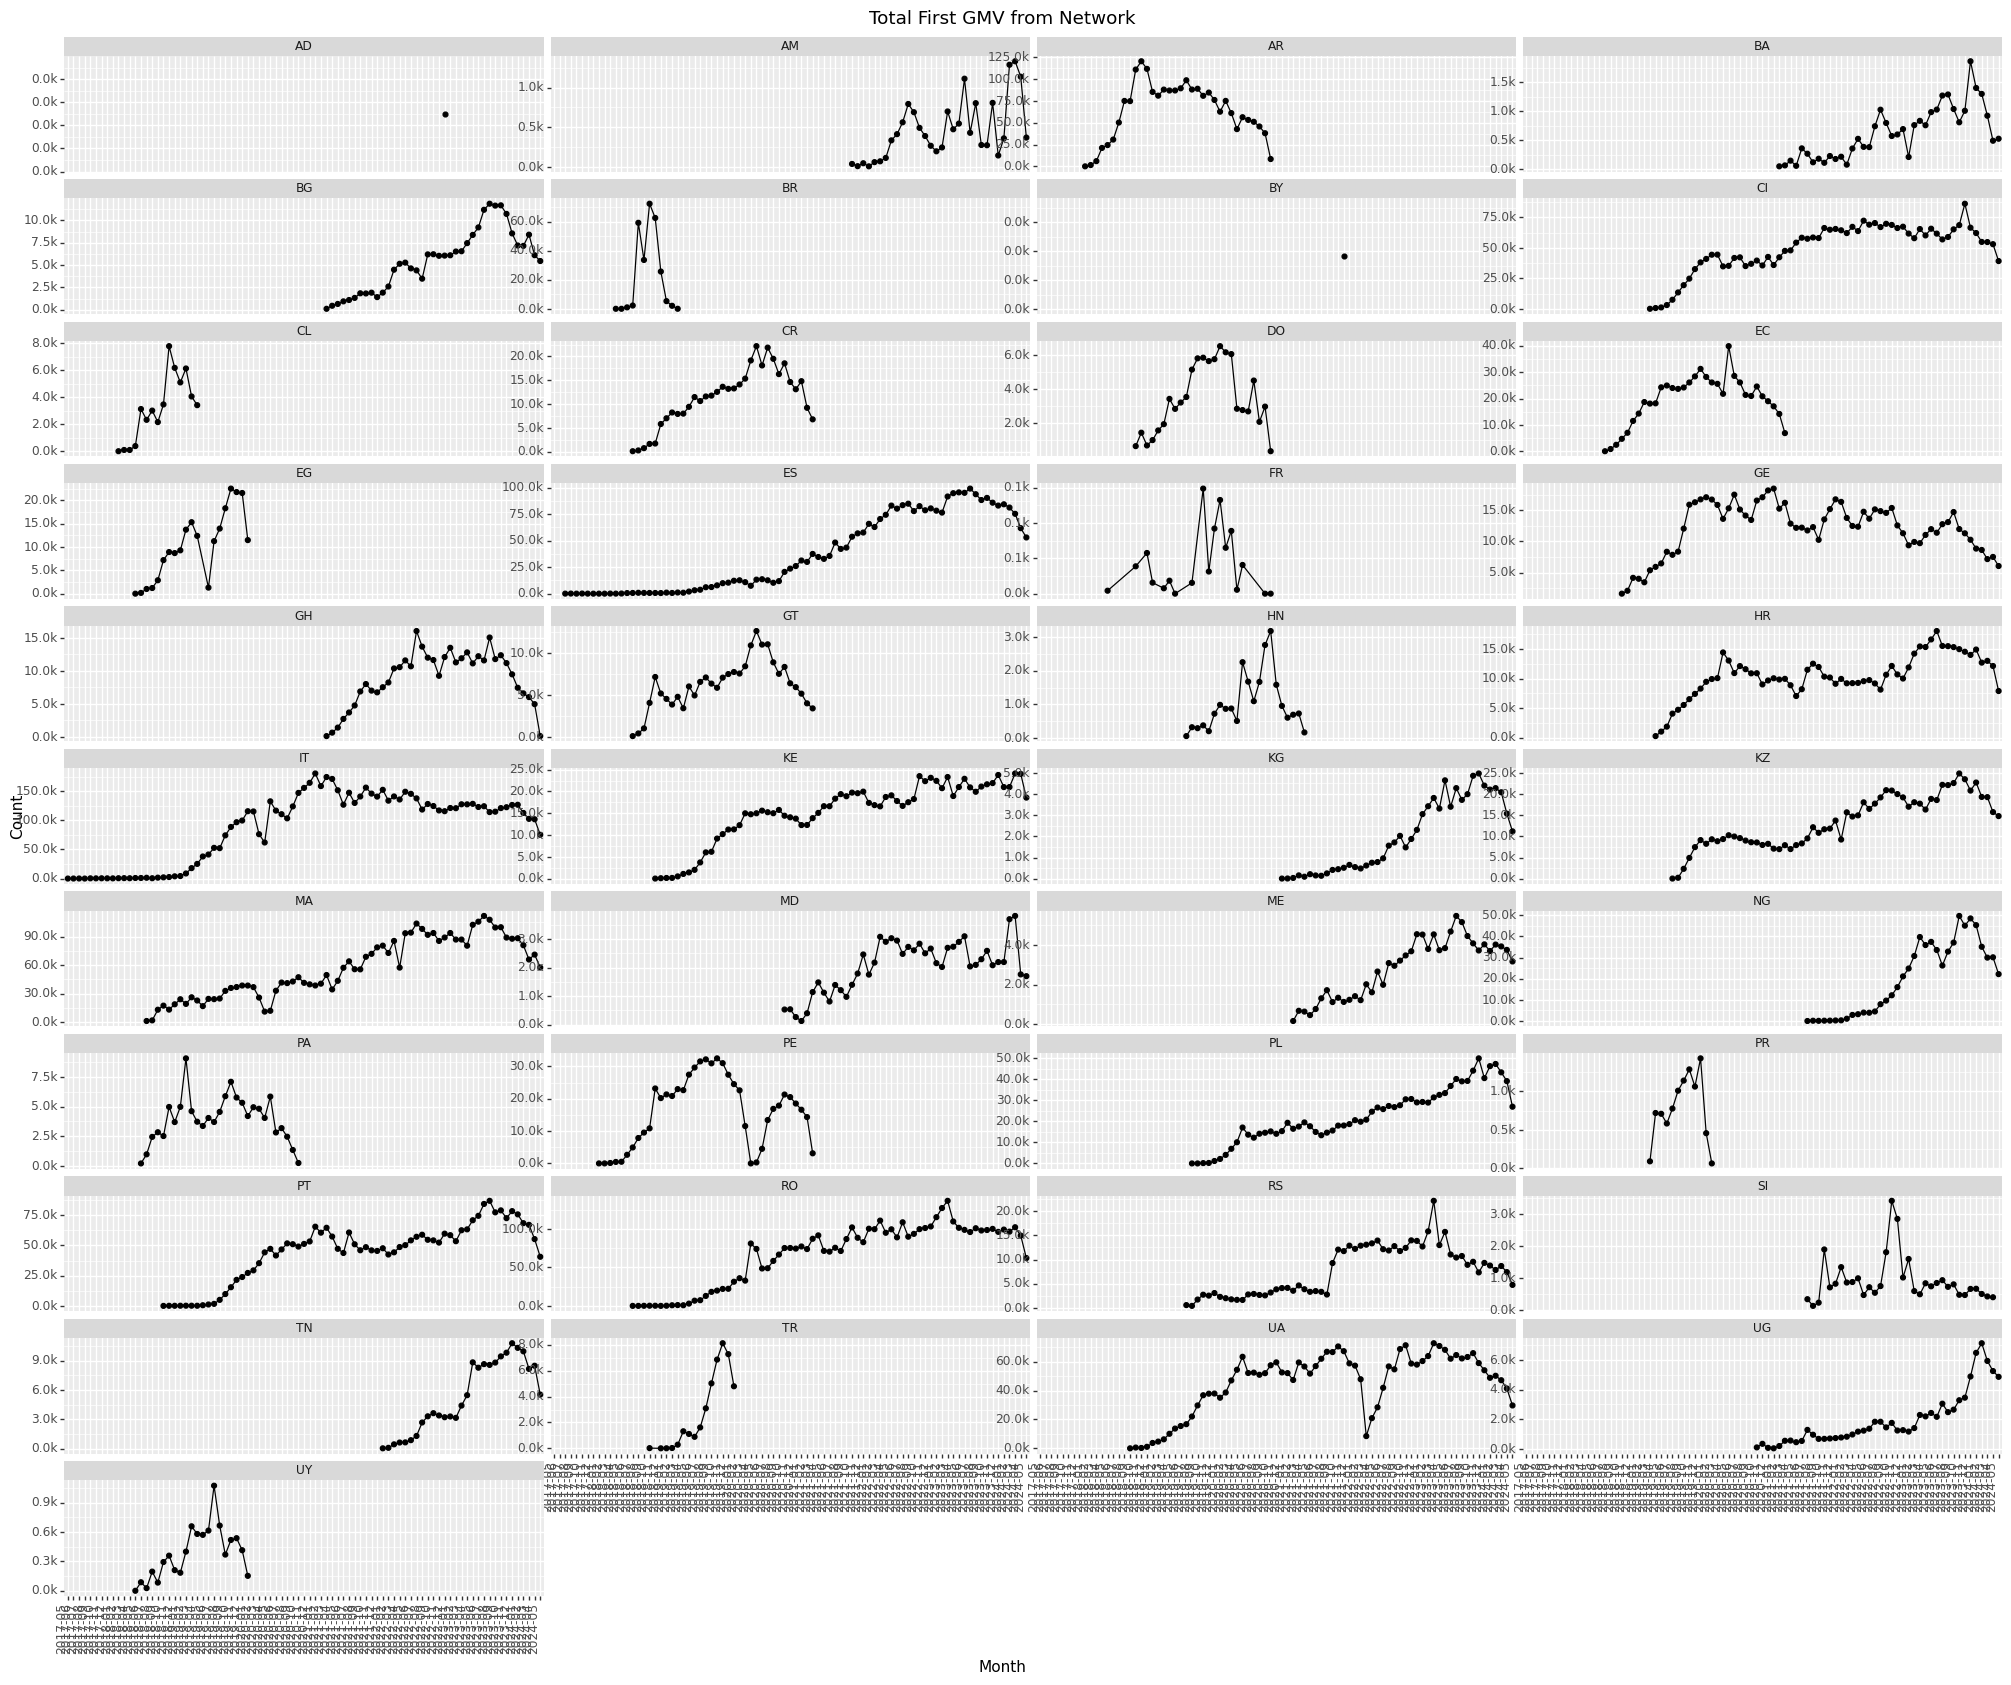

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


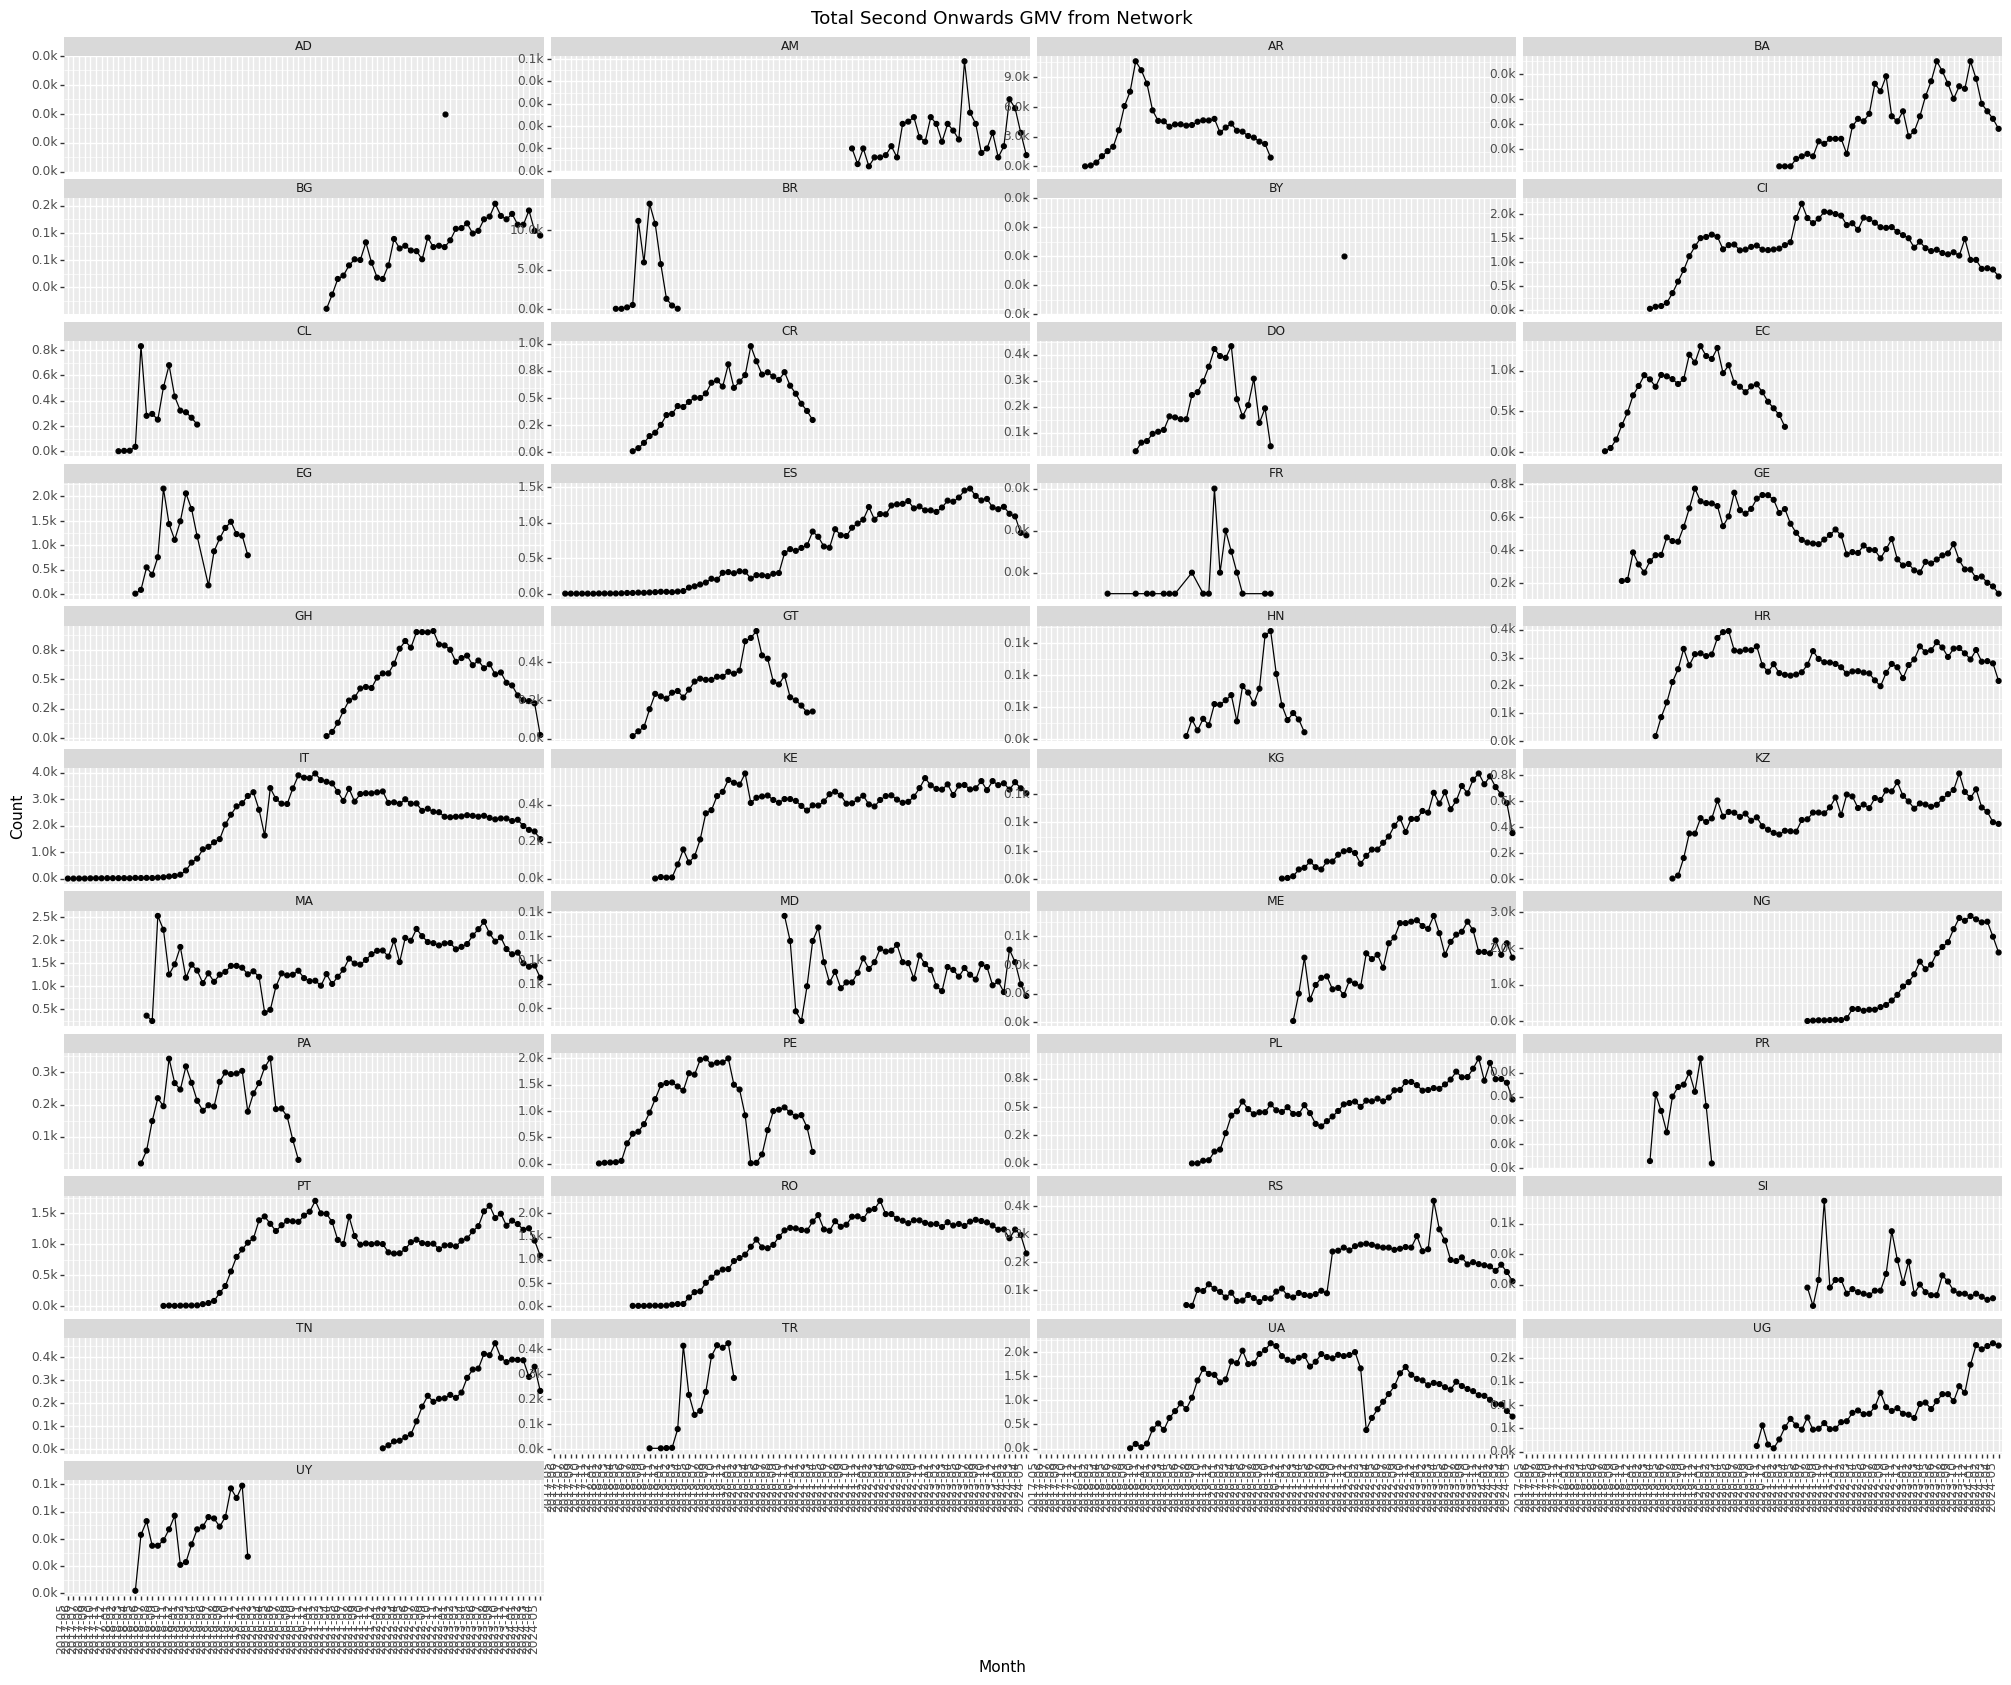

In [316]:
plot1 =     (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='gmv', group='order_country_code')) +
    pn.geom_line() +
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    # pn.facet_wrap('~order_country_code', scales="free_y", ncol=4) +
     pn.labs(x='Month', y='Count', title='Total First GMV from Network')+
     pn.facet_wrap('~order_country_code', scales="free_y", ncol=4) 
        +            
     pn.theme(figure_size=(25, 20),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )
# Create the second plot
plot2 = (pn.ggplot(month_diff, pn.aes(x='order_date_month', y='total_customers', group='order_country_code')) +
    pn.geom_line() +#pn.geom_bar(stat='identity', fill="lightgreen") +  # Changed from pn.geom_line() to pn.geom_bar(stat='identity')
    pn.geom_point() +
    pn.scale_y_continuous( labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.labs(x='Month', y='Count', title='Total Second Onwards GMV from Network')+
    pn.facet_wrap('~order_country_code', scales="free_y", ncol=4) +            
    pn.theme(figure_size=(25, 20),
        axis_text_x=pn.element_text(rotation=90, hjust=1)
            )
            )

print(plot1)
print(plot2)

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 8 rows containing missing values.


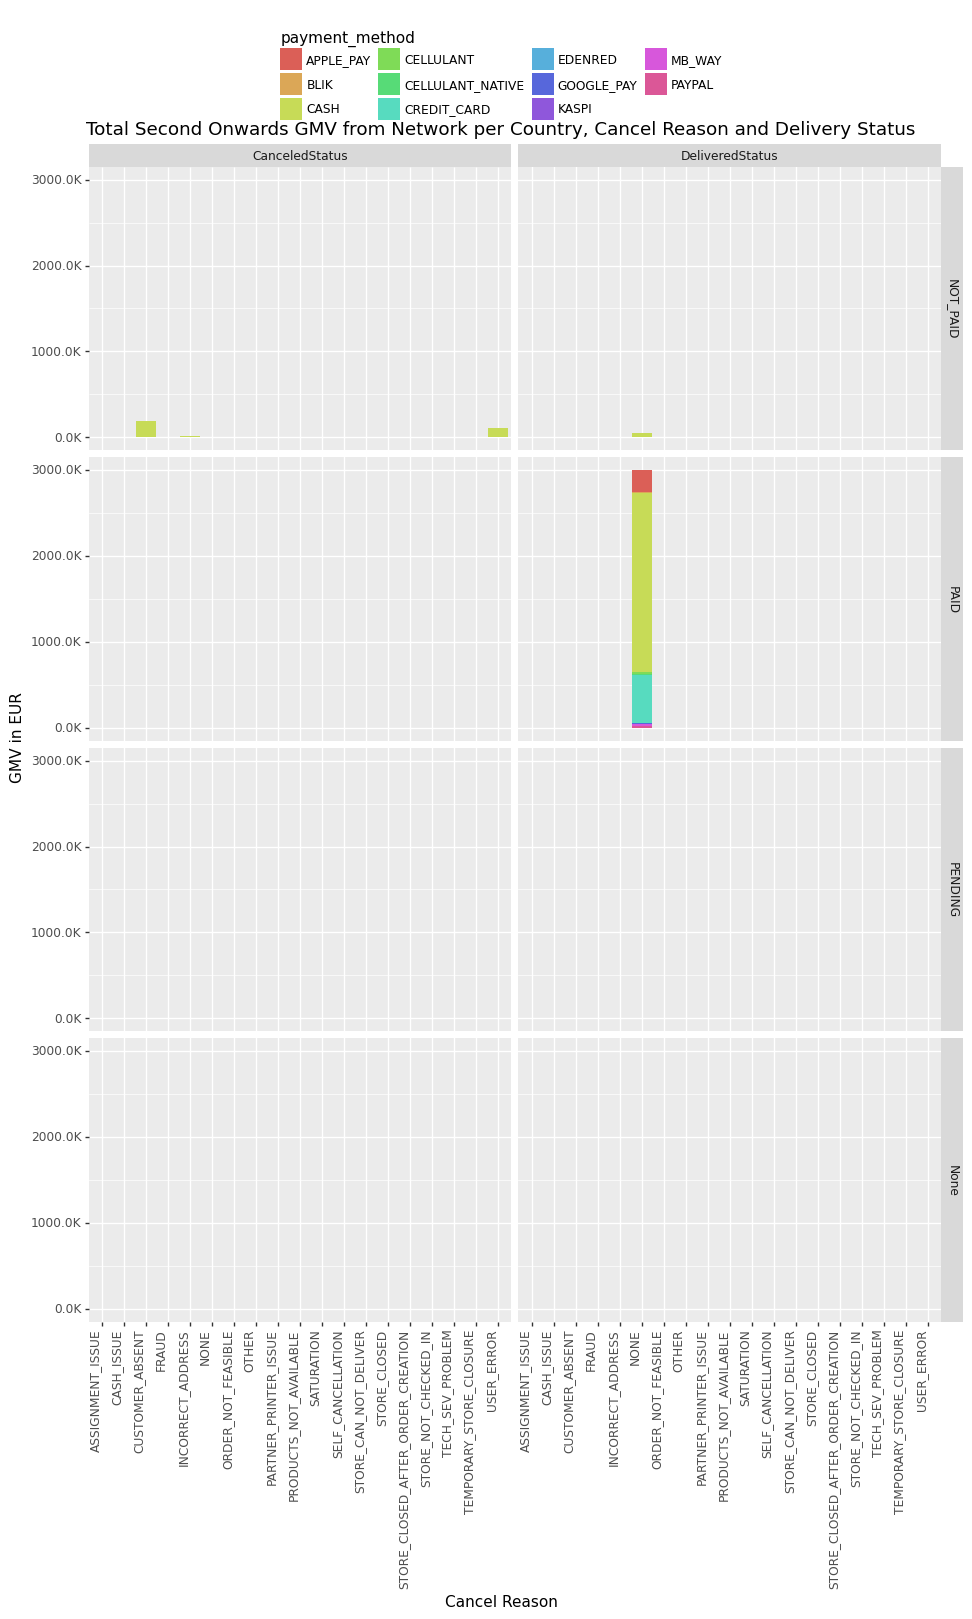

<ggplot: (821140357)>

In [318]:
(
    pn.ggplot(df2.query("date>= '2024-01-01'")#.query('order_country_code in ["CI","ES","HR","IT", "AM","BA","GE","KE","KG","KZ"]')# "AM","BA","GE","KE","KG","KZ"
    , pn.aes(x='order_cancel_reason', y='gmv', fill='payment_method')) +
    pn.geom_col() +
    pn.facet_grid('payment_status~order_final_status') +
    pn.labs(x='Cancel Reason', y='GMV in EUR', title='Total Second Onwards GMV from Network per Country, Cancel Reason and Delivery Status')+
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(angle=90, hjust=1), legend_position='top', figure_size=(11,15))
)

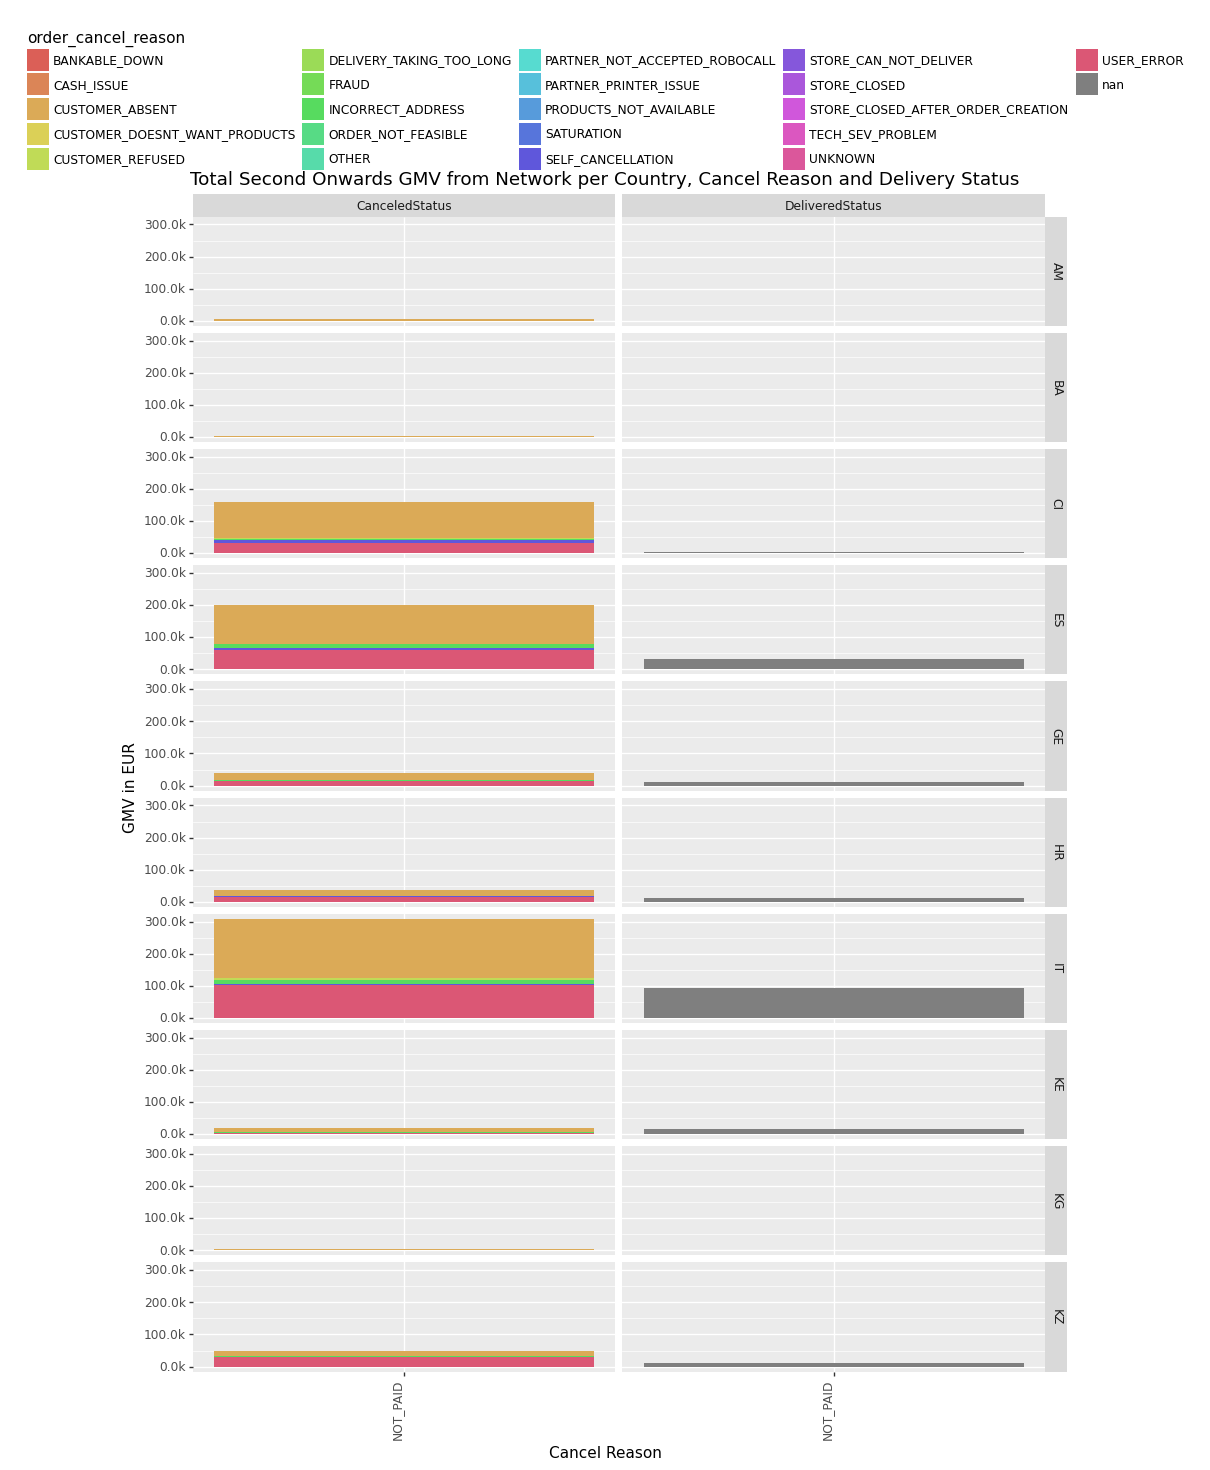

<ggplot: (786036497)>

In [446]:
(
    pn.ggplot(df2.query('order_country_code in ["CI","ES","HR","IT", "AM","BA","GE","KE","KG","KZ"] and payment_status == "NOT_PAID"')# "AM","BA","GE","KE","KG","KZ"
    , pn.aes(x='payment_status', y='gmv', fill='order_cancel_reason')) +
    pn.geom_col() +
    pn.facet_grid('order_country_code~order_final_status') +
    pn.labs(x='Cancel Reason', y='GMV in EUR', title='Total Second Onwards GMV from Network per Country, Cancel Reason and Delivery Status')+
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(angle=90, hjust=1), legend_position='top', figure_size=(11,15))
)

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 613 rows containing missing values.


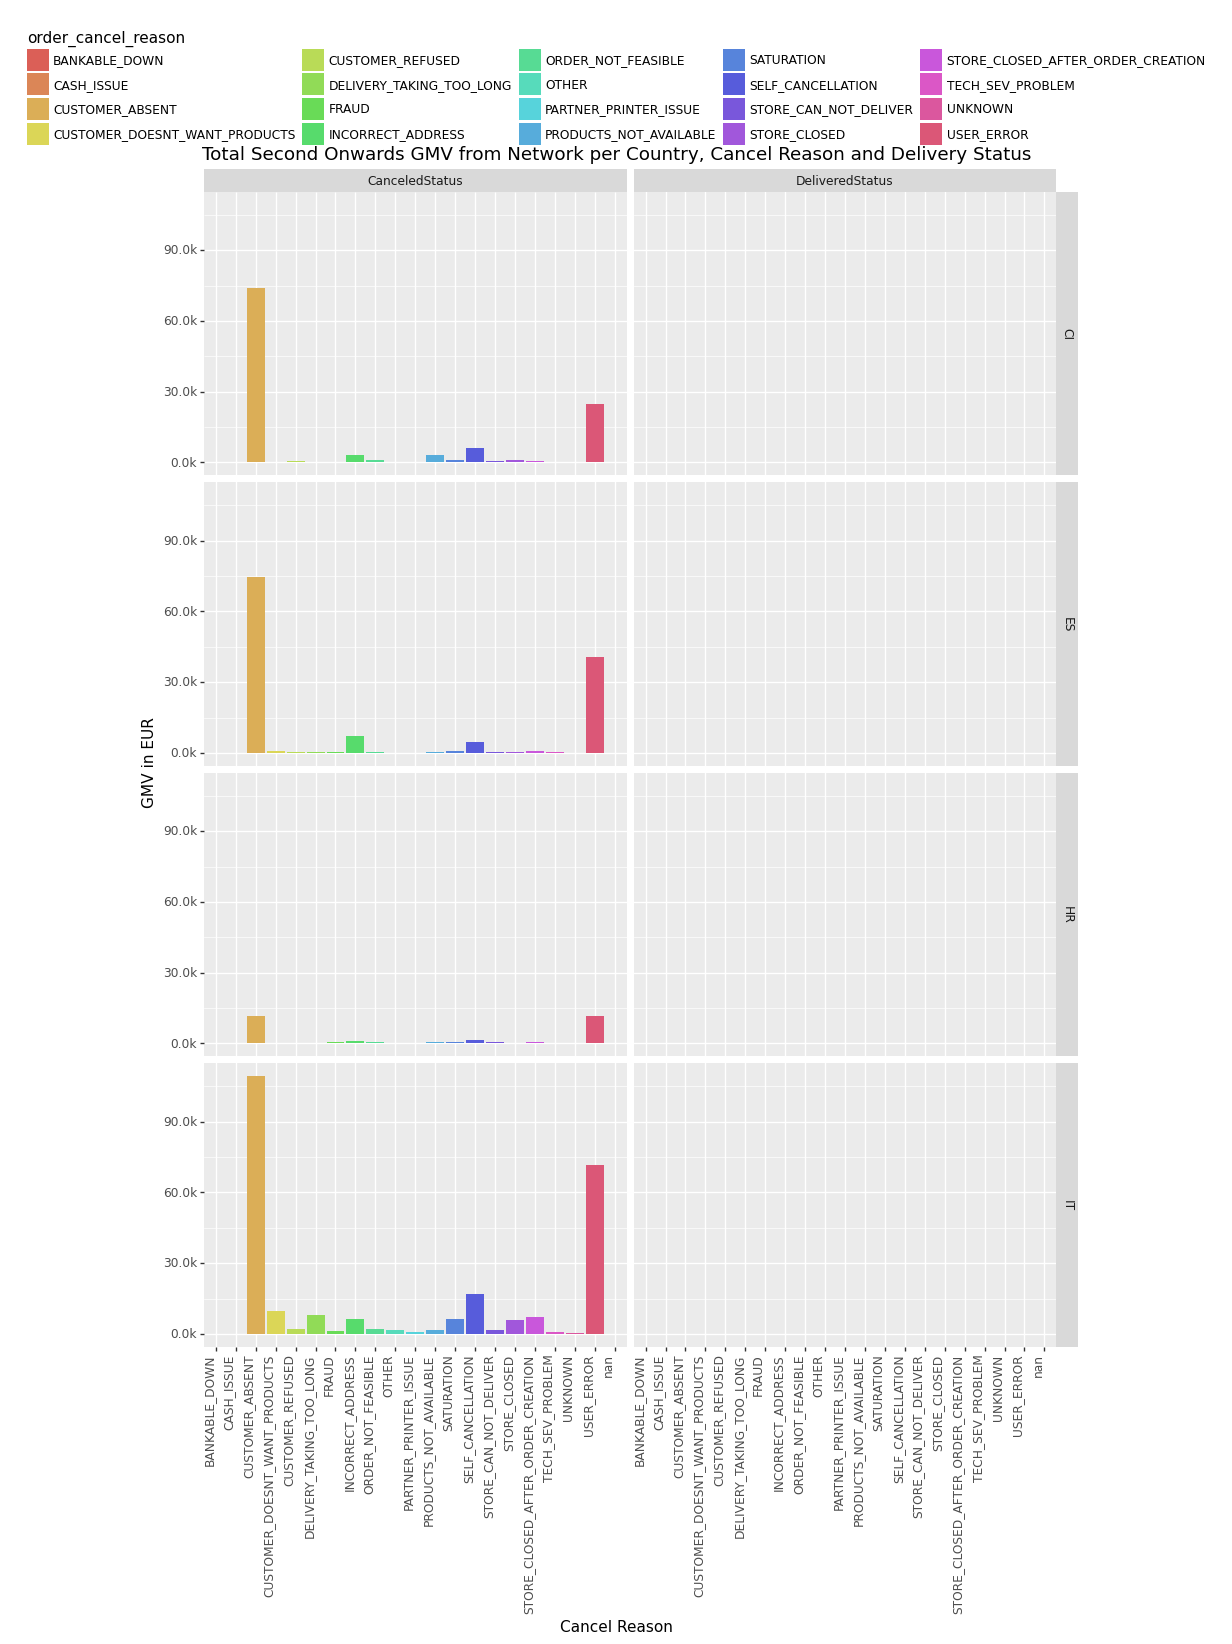

<ggplot: (681788117)>

In [450]:
(
    pn.ggplot(df2.query('order_country_code in ["CI","ES","HR","IT"] and payment_status == "NOT_PAID"')# "AM","BA","GE","KE","KG","KZ"
    , pn.aes(x='order_cancel_reason', y='second_onwards_network_estimated_gmv', fill='order_cancel_reason')) +
    pn.geom_col() +
    pn.facet_grid('order_country_code~order_final_status') +
    pn.labs(x='Cancel Reason', y='GMV in EUR', title='Total Second Onwards GMV from Network per Country, Cancel Reason and Delivery Status')+
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(angle=90, hjust=1), legend_position='top', figure_size=(11,15))
)

/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 928 rows containing missing values.


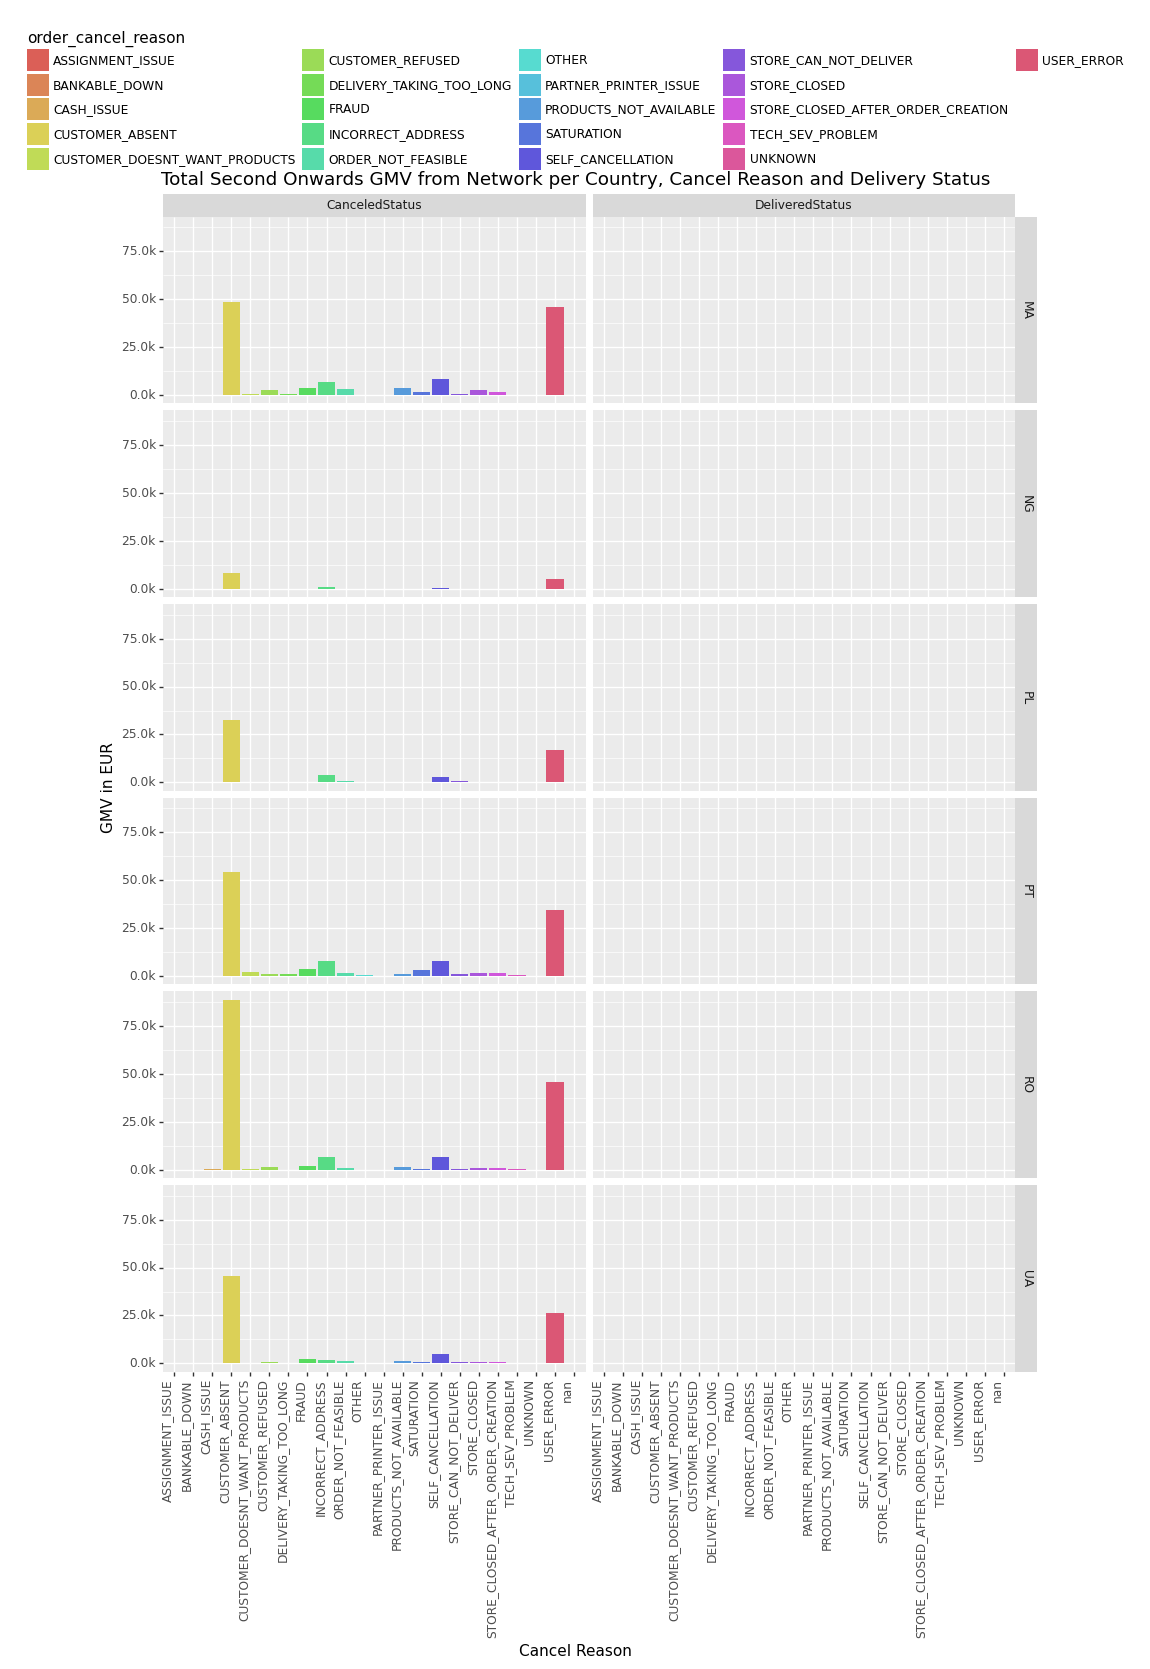

<ggplot: (809319461)>

In [451]:
(
    pn.ggplot(df2.query('order_country_code in ["MA","NG","PL","PT","RO","UA"] and payment_status == "NOT_PAID"')#,"MD","ME","TN","UG"
    , pn.aes(x='order_cancel_reason', y='second_onwards_network_estimated_gmv', fill='order_cancel_reason')) +
    pn.geom_col() +
    pn.facet_grid('order_country_code~order_final_status') +
    pn.labs(x='Cancel Reason', y='GMV in EUR', title='Total Second Onwards GMV from Network per Country, Cancel Reason and Delivery Status')+
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(angle=90, hjust=1), legend_position='top', figure_size=(11,15))
)

### CASH NETWORKS PROFITABILITY ANALYSIS

In [422]:
month_ = df2.query("payment_method == 'CASH'").groupby(
    ['date', 'payment_status'], as_index=False
).agg(
    gmv=('gmv', 'sum'),
    cm=('cm', 'sum')
)

# Convert 'date' to datetime format
month_2['date'] = pd.to_datetime(month['date'])

# Pivot the data to have 'date' as rows, 'payment_status' as columns, and 'gmv' and 'cm' as values
pivot_gmv_2= month_2.pivot(index='date', columns='payment_status', values='gmv').add_prefix('gmv_')
pivot_cm_2 = month_2.pivot(index='date', columns='payment_status', values='cm').add_prefix('cm_')

# Calculate cumulative sums for each column in the pivoted DataFrames
pivot_gmv_cumsum_2 = pivot_gmv_2.cumsum()
pivot_cm_cumsum_2 = pivot_cm_2.cumsum()

# Combine the cumulative sum DataFrames
pivot_wide_cumsum_2 = pd.concat([pivot_gmv_cumsum_2, pivot_cm_cumsum_2], axis=1).reset_index()

# Filter for specific combinations if necessary (e.g., 'gmv_NOT_PAID' and 'cm_PAID')
# This step is optional and based on your specific plotting needs
filtered_combinations_2 = pivot_wide_cumsum_2[['date', 'gmv_NOT_PAID', 'cm_PAID']]

plot_data_2 = pd.melt(filtered_combinations_2, id_vars=['date'], var_name='metric_status', value_name='cumulative_sum')
plot_data_2

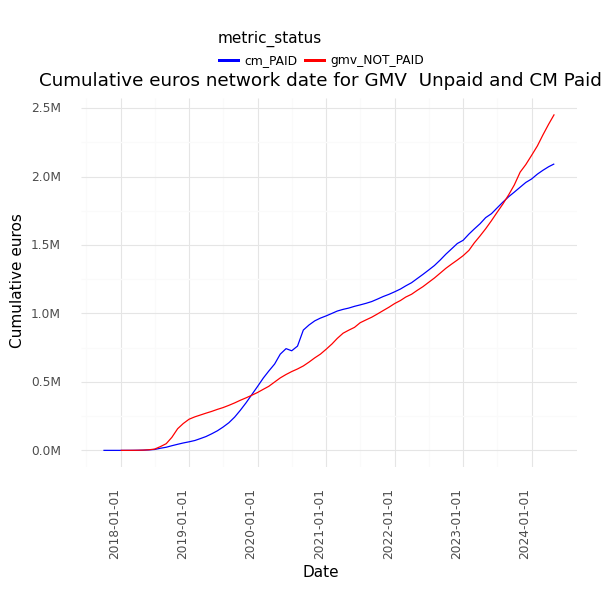

<ggplot: (291119425)>

In [424]:
(
    pn.ggplot(plot_data_2, pn.aes(x='date', y='cumulative_sum', color='metric_status')) +
        pn.geom_line() +
        pn.labs(title='Cumulative euros network date for GMV  Unpaid and CM Paid',
             x='Date',
             y='Cumulative euros') +
        pn.scale_y_continuous(labels=lambda l: ['{:.1f}M'.format(v / 1000000) for v in l]) +
        #pn.scale_x_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
        pn.scale_color_manual(values={'gmv_NOT_PAID': 'red', 'cm_PAID': 'blue'}) +
       #pn.theme(axis_text_x=pn.element_text(angle=90, hjust=1), legend_position='top') +
        pn.theme_minimal() +
        pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1), legend_position='top')

)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_47978/2432689225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_47978/2432689225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : 

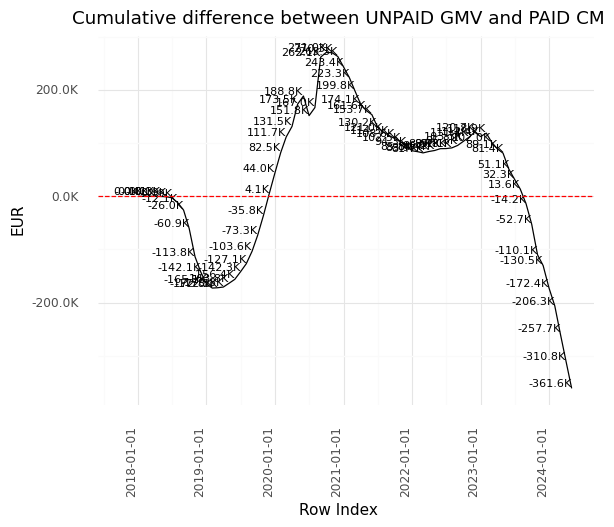

<ggplot: (807567533)>

In [427]:
filtered_combinations_2['diff']=filtered_combinations_2['cm_PAID']-filtered_combinations_2['gmv_NOT_PAID']
filtered_combinations_2['diff_label'] = filtered_combinations_2['diff'].apply(lambda x: '{:.1f}K'.format(x / 1000))
filtered_combinations_2

(
    pn.ggplot(filtered_combinations_2, pn.aes(x='date', y='diff')) +
    pn.geom_line() +
    pn.geom_text(pn.aes(label='diff_label'), va='bottom', ha='right', size=8) +
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.geom_hline(yintercept=0, linetype="dashed", color="red") +
    pn.labs(title='Cumulative difference between UNPAID GMV and PAID CM', x='Row Index', y='EUR') +
    pn.theme_minimal() +
    pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1), legend_position='top')
)

### SECOND CUSTOMER NETOWORK

In [452]:
month_2 = df2.query("payment_method == 'CASH'").groupby(
    ['date', 'payment_status'], as_index=False
).agg(
    gmv=('second_onwards_network_gmv', 'sum'),
    cm=('second_onwards_network_cm', 'sum')
)

# Convert 'date' to datetime format
month_2['date'] = pd.to_datetime(month['date'])

# Pivot the data to have 'date' as rows, 'payment_status' as columns, and 'gmv' and 'cm' as values
pivot_gmv_2= month_2.pivot(index='date', columns='payment_status', values='gmv').add_prefix('gmv_')
pivot_cm_2 = month_2.pivot(index='date', columns='payment_status', values='cm').add_prefix('cm_')

# Calculate cumulative sums for each column in the pivoted DataFrames
pivot_gmv_cumsum_2 = pivot_gmv_2.cumsum()
pivot_cm_cumsum_2 = pivot_cm_2.cumsum()

# Combine the cumulative sum DataFrames
pivot_wide_cumsum_2 = pd.concat([pivot_gmv_cumsum_2, pivot_cm_cumsum_2], axis=1).reset_index()

# Filter for specific combinations if necessary (e.g., 'gmv_NOT_PAID' and 'cm_PAID')
# This step is optional and based on your specific plotting needs
filtered_combinations_2 = pivot_wide_cumsum_2[['date', 'gmv_NOT_PAID', 'cm_PAID']]

plot_data_2 = pd.melt(filtered_combinations_2, id_vars=['date'], var_name='metric_status', value_name='cumulative_sum')
plot_data_2

date metric_status  cumulative_sum
0   2017-10-01  gmv_NOT_PAID             NaN
1   2017-12-01  gmv_NOT_PAID             NaN
2   2018-01-01  gmv_NOT_PAID    0.000000e+00
3   2018-02-01  gmv_NOT_PAID    9.832644e+01
4   2018-03-01  gmv_NOT_PAID    9.832644e+01
..         ...           ...             ...
153 2024-01-01       cm_PAID    1.138359e+06
154 2024-02-01       cm_PAID    1.169261e+06
155 2024-03-01       cm_PAID    1.194172e+06
156 2024-04-01       cm_PAID    1.218436e+06
157 2024-05-01       cm_PAID    1.237133e+06

[158 rows x 3 columns]

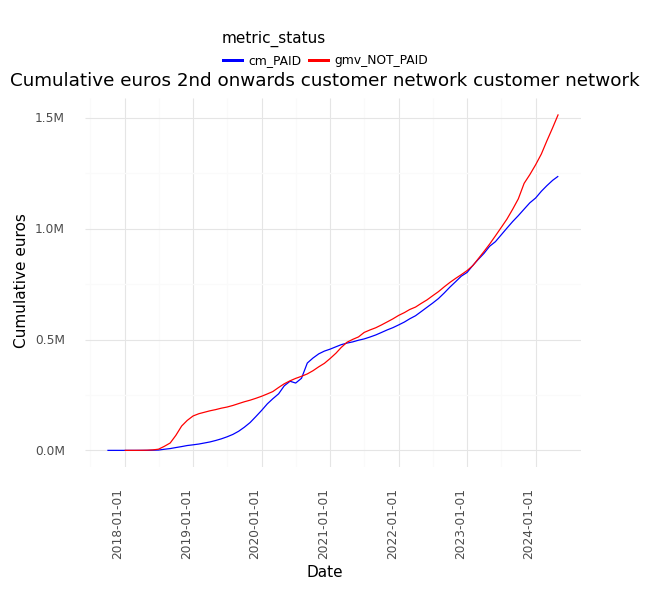

<ggplot: (792964853)>

In [453]:
(
    pn.ggplot(plot_data_2, pn.aes(x='date', y='cumulative_sum', color='metric_status')) +
        pn.geom_line() +
        pn.labs(title='Cumulative euros 2nd onwards customer network customer network',
             x='Date',
             y='Cumulative euros') +
        pn.scale_y_continuous(labels=lambda l: ['{:.1f}M'.format(v / 1000000) for v in l]) +
        #pn.scale_x_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
        pn.scale_color_manual(values={'gmv_NOT_PAID': 'red', 'cm_PAID': 'blue'}) +
       #pn.theme(axis_text_x=pn.element_text(angle=90, hjust=1), legend_position='top') +
        pn.theme_minimal() +
        pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1), legend_position='top')

)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_47978/1162019210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_47978/1162019210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : 

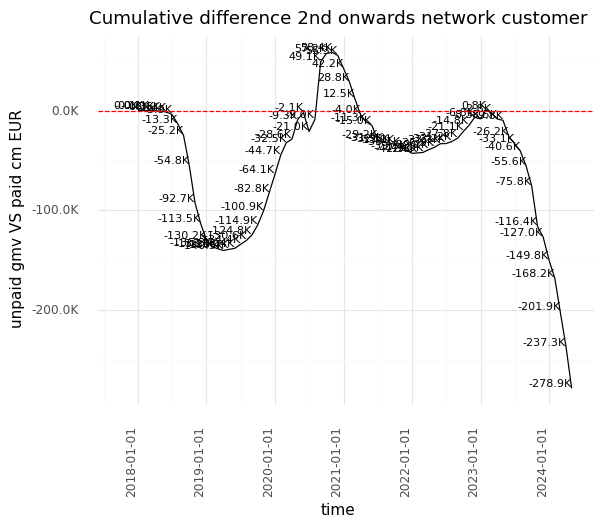

<ggplot: (810621065)>

In [454]:
filtered_combinations_2['diff']=filtered_combinations_2['cm_PAID']-filtered_combinations_2['gmv_NOT_PAID']
filtered_combinations_2['diff_label'] = filtered_combinations_2['diff'].apply(lambda x: '{:.1f}K'.format(x / 1000))
filtered_combinations_2

(
    pn.ggplot(filtered_combinations_2, pn.aes(x='date', y='diff')) +
    pn.geom_line() +
    pn.geom_text(pn.aes(label='diff_label'), va='bottom', ha='right', size=8) +
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.geom_hline(yintercept=0, linetype="dashed", color="red") +
    pn.labs(title='Cumulative difference 2nd onwards network customer', x='time', y='unpaid gmv VS paid cm EUR') +
    pn.theme_minimal() +
    pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1), legend_position='top')
)

### FIRST CUSTOMER NETOWORK

In [455]:
month_2 = df2.query("payment_method == 'CASH'").groupby(
    ['date', 'payment_status'], as_index=False
).agg(
    gmv=('frist_network_gmv', 'sum'),
    cm=('frist_network_estimated_cm', 'sum')
)

# Convert 'date' to datetime format
month_2['date'] = pd.to_datetime(month['date'])

# Pivot the data to have 'date' as rows, 'payment_status' as columns, and 'gmv' and 'cm' as values
pivot_gmv_2= month_2.pivot(index='date', columns='payment_status', values='gmv').add_prefix('gmv_')
pivot_cm_2 = month_2.pivot(index='date', columns='payment_status', values='cm').add_prefix('cm_')

# Calculate cumulative sums for each column in the pivoted DataFrames
pivot_gmv_cumsum_2 = pivot_gmv_2.cumsum()
pivot_cm_cumsum_2 = pivot_cm_2.cumsum()

# Combine the cumulative sum DataFrames
pivot_wide_cumsum_2 = pd.concat([pivot_gmv_cumsum_2, pivot_cm_cumsum_2], axis=1).reset_index()

# Filter for specific combinations if necessary (e.g., 'gmv_NOT_PAID' and 'cm_PAID')
# This step is optional and based on your specific plotting needs
filtered_combinations_2 = pivot_wide_cumsum_2[['date', 'gmv_NOT_PAID', 'cm_PAID']]

plot_data_2 = pd.melt(filtered_combinations_2, id_vars=['date'], var_name='metric_status', value_name='cumulative_sum')
plot_data_2

date metric_status  cumulative_sum
0   2017-10-01  gmv_NOT_PAID             NaN
1   2017-12-01  gmv_NOT_PAID             NaN
2   2018-01-01  gmv_NOT_PAID        0.000000
3   2018-02-01  gmv_NOT_PAID       95.272825
4   2018-03-01  gmv_NOT_PAID      171.988610
..         ...           ...             ...
153 2024-01-01       cm_PAID   844012.449009
154 2024-02-01       cm_PAID   848595.862978
155 2024-03-01       cm_PAID   851263.599821
156 2024-04-01       cm_PAID   853454.761389
157 2024-05-01       cm_PAID   855505.540310

[158 rows x 3 columns]

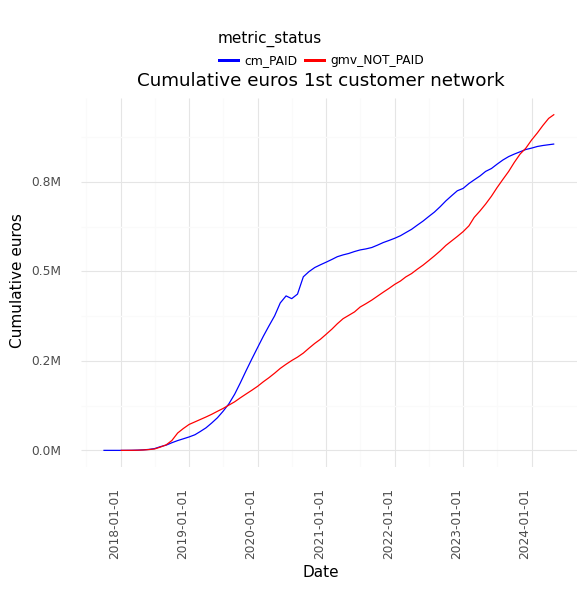

<ggplot: (800205537)>

In [459]:
(
    pn.ggplot(plot_data_2, pn.aes(x='date', y='cumulative_sum', color='metric_status')) +
        pn.geom_line() +
        pn.labs(title='Cumulative euros 1st customer network',
             x='Date',
             y='Cumulative euros') +
        pn.scale_y_continuous(labels=lambda l: ['{:.1f}M'.format(v / 1000000) for v in l]) +
        #pn.scale_x_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
        pn.scale_color_manual(values={'gmv_NOT_PAID': 'red', 'cm_PAID': 'blue'}) +
       #pn.theme(axis_text_x=pn.element_text(angle=90, hjust=1), legend_position='top') +
        pn.theme_minimal() +
        pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1), legend_position='top')

)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_47978/1955157764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_47978/1955157764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
/Applications/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : 

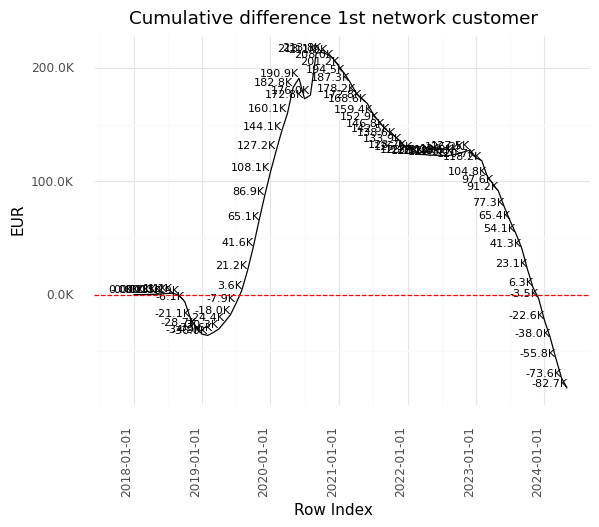

<ggplot: (800072473)>

In [457]:
filtered_combinations_2['diff']=filtered_combinations_2['cm_PAID']-filtered_combinations_2['gmv_NOT_PAID']
filtered_combinations_2['diff_label'] = filtered_combinations_2['diff'].apply(lambda x: '{:.1f}K'.format(x / 1000))
filtered_combinations_2

(
    pn.ggplot(filtered_combinations_2, pn.aes(x='date', y='diff')) +
    pn.geom_line() +
    pn.geom_text(pn.aes(label='diff_label'), va='bottom', ha='right', size=8) +
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.geom_hline(yintercept=0, linetype="dashed", color="red") +
    pn.labs(title='Cumulative difference 1st network customer', x='Row Index', y='EUR') +
    pn.theme_minimal() +
    pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1), legend_position='top')
)

# INFORMATION PER DEVICE AND CUSTOMER

In [113]:
## Starbust credentials (this works alone, no need to modify)
HOST = 'starburst.g8s-data-platform-prod.glovoint.com'
PORT = 443


conn_details = {
    'host': HOST,
    'port': PORT,
    'http_scheme': 'https',
    'auth': trino.auth.OAuth2Authentication()
}

In [229]:
query3='''

WITH cash_unpaid_network AS (

SELECT *, row_number() over (PARTITION BY device_id   order by first_order_date asc) as first_network_user_count -- Understand the network count
        , row_number() over (PARTITION BY device_id   order by first_order_date desc) as last_network_number_count -- how big the network is connected to the device
FROM(SELECT  MIN(o.order_created_at) AS first_order_date, o.device_id, o.customer_id FROM delta.central_order_descriptors_odp.order_descriptors_v2 o LEFT JOIN delta.fintech_payments_odp.payments p ON p.order_id = o.order_id WHERE TRUE AND  p.payment_status='NOT_PAID' AND p.payment_method='CASH' AND -- WITH THE FILTER OF BELOW i GET THE DEVICE CASH UNPAID NETWORKS, MEANING NETWORKS WITH 2 OR MORE CUSTOMERS SHARING DEVICE WITH CASH UNPAID EACH
                        o.device_id IN (SELECT DISTINCT o.device_id  FROM delta.central_order_descriptors_odp.order_descriptors_v2 o LEFT JOIN delta.fintech_payments_odp.payments p ON p.order_id = o.order_id GROUP BY o.device_id HAVING COUNT(DISTINCT CASE WHEN p.payment_status='NOT_PAID' AND p.payment_method='CASH' THEN o.customer_id ELSE NULL END) > 1) GROUP BY 2,3) -- Con esto tengo networks de unpaid que tienen más de 1 user
)       

, ADDED AS (
SELECT 
        -- order 
        cn.first_order_date
        , cn.device_id
        , cn.customer_id
        , cn.first_network_user_count -- Understand the network count
        , cn.last_network_number_count -- how big the network is connected to the device
       , row_number() over (PARTITION BY o.order_id  order by o.order_created_at asc) as first_order_id -- security_check
       , o.order_created_at
       , o.order_country_code
       , o.order_id
        , o.order_final_status
        , o.order_cancel_reason
        , o.order_total_purchase_eur
        , o.order_estimated_purchase_eur
        -- payment
        , p.payment_status
        , p.payment_method
        -- cm
        , cm.gmvalu_eur AS GMV_cm_table
        , cm.contribution_margin_eur 
FROM  cash_unpaid_network cn 
        LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2 o ON o.device_id = cn.device_id AND o.customer_id = cn.customer_id
        LEFT JOIN delta.fintech_payments_odp.payments p                      ON p.order_id  = o.order_id
        LEFT JOIN delta.finance_financial_reports_odp.pnl_order_level cm ON cm.order_id=o.order_id         
WHERE TRUE --AND  p.payment_status='NOT_PAID' AND p.payment_method='CASH' 
)

SELECT --DATE(DATE_TRUNC('month', order_created_at)) AS date
       --, order_country_code -- could be checked later
        --,
         device_id
        , customer_id
        , first_network_user_count
        , last_network_number_count
-- HOW MUCH PAID and FROM which payment methods they have it
-- i THINK IS MORE INTERESTING HOW MANY PAID, UNPAID, PER DEVICE, HOW MANY DIFFERENT CUSTOMERS AND ORDERS, ETC, SO WE CAN CLASSIFY HOW MANY OF UNPAID NETWORKS HAS MORE UNPAID THAN PAID
-- ALTER DF AS IF IT'S THE BOT DEFINITION ANALYSIS
-- SEVERAL COLUMNS FOR HAVING THE INFORMATION PER DEVICE, INSTEAD OF GROUPED BY and check which device network is more fraudulent than the other. I can fully check total orders count per customer here and per device network.
-- calculate total orders count per customer is usefull. I will group by everything per device and customer, check if is possible to use it in python or query it alone.
-- This will help to detect fraud netwroks, as well will add cm table to compare impact of fraud vs orders to actually check if it has trade off.
       --, order_final_status
       --, order_cancel_reason
       --, payment_status
       --, payment_method
       --, COUNT(DISTINCT device_id) AS total_devices
       --, COUNT(DISTINCT customer_id) AS total_customers
       , COUNT(DISTINCT order_id) AS total_orders
       , COUNT(DISTINCT CASE WHEN order_cancel_reason='CUSTOMER_ABSCENT' THEN order_id ELSE NULL END)  AS cusomer_absent_orders
       , SUM(CASE WHEN first_order_id=1 THEN order_total_purchase_eur ELSE NULL END) AS gmv
        
      , COUNT(DISTINCT CASE WHEN payment_status='PAID' THEN order_id ELSE NULL END) AS total_PAID_orders
      , COUNT(DISTINCT CASE WHEN payment_status='NOT_PAID' THEN order_id ELSE NULL END) AS total_NOT_PAID_orders
      
      , SUM(CASE WHEN first_order_id=1 AND payment_status='PAID' THEN order_total_purchase_eur ELSE NULL END) AS PAID_gmv
      , SUM(CASE WHEN first_order_id=1 AND payment_status='NOT_PAID' THEN order_total_purchase_eur ELSE NULL END) AS NOT_PAID_gmv


      , COUNT(DISTINCT CASE WHEN payment_method='CASH' THEN order_id ELSE NULL END) AS CASH_orders
      , COUNT(DISTINCT CASE WHEN payment_method='CREDIT_CARD' THEN order_id ELSE NULL END) AS CREDIT_CARD_orders
      , COUNT(DISTINCT CASE WHEN payment_method='PAYPAL' THEN order_id ELSE NULL END) AS PAYPAL_orders
      , COUNT(DISTINCT CASE WHEN payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL')  THEN order_id ELSE NULL END) AS alternative_orders
      
      , COUNT(DISTINCT CASE WHEN payment_method='CASH' AND payment_status='PAID' THEN order_id ELSE NULL END) AS cash_paid
      , COUNT(DISTINCT CASE WHEN payment_method='CASH' AND payment_status='NOT_PAID' THEN order_id ELSE NULL END) AS cash_unpaid

      , COUNT(DISTINCT CASE WHEN payment_method='CREDIT_CARD' AND payment_status='PAID' THEN order_id ELSE NULL END) AS credit_card_paid
      , COUNT(DISTINCT CASE WHEN payment_method='CREDIT_CARD' AND payment_status='NOT_PAID' THEN order_id ELSE NULL END) AS credit_card_unpaid

      , COUNT(DISTINCT CASE WHEN payment_method='PAYPAL' AND payment_status='PAID' THEN order_id ELSE NULL END) AS PAYPAL_paid
      , COUNT(DISTINCT CASE WHEN payment_method='PAYPAL' AND payment_status='NOT_PAID' THEN order_id ELSE NULL END) AS PAYPAL_unpaid

      , COUNT(DISTINCT CASE WHEN payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL')  AND payment_status='PAID'  THEN order_id ELSE NULL END) AS alternative_paid
      , COUNT(DISTINCT CASE WHEN payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL')  AND payment_status='NOT_PAID'  THEN order_id ELSE NULL END) AS alternative_unpaid
      
      , COUNT(DISTINCT CASE WHEN payment_method='CASH' AND payment_status='PAID'     AND order_final_status='DeliveredStatus' THEN order_id ELSE NULL END) AS cash_paid_delivered_order
      , COUNT(DISTINCT CASE WHEN payment_method='CASH' AND payment_status='NOT_PAID' AND order_final_status='DeliveredStatus' THEN order_id ELSE NULL END) AS cash_NOT_paid_delivered_order
      , COUNT(DISTINCT CASE WHEN payment_method='CASH' AND payment_status='NOT_PAID' AND order_final_status='CanceledStatus'  THEN order_id ELSE NULL END) AS cash_NOT_paid_canceled_order

      , COUNT(DISTINCT CASE WHEN payment_method='CREDIT_CARD' AND payment_status='PAID'     AND order_final_status='DeliveredStatus' THEN order_id ELSE NULL END) AS credit_card_paid_delivered_order
      , COUNT(DISTINCT CASE WHEN payment_method='CREDIT_CARD' AND payment_status='NOT_PAID' AND order_final_status='DeliveredStatus' THEN order_id ELSE NULL END) AS credit_card_NOT_paid_delivered_order
      , COUNT(DISTINCT CASE WHEN payment_method='CREDIT_CARD' AND payment_status='NOT_PAID' AND order_final_status='CanceledStatus'  THEN order_id ELSE NULL END) AS credit_card_NOT_paid_canceled_order

      , COUNT(DISTINCT CASE WHEN payment_method='PAYPAL' AND payment_status='PAID'     AND order_final_status='DeliveredStatus' THEN order_id ELSE NULL END) AS paypal_paid_delivered_order
      , COUNT(DISTINCT CASE WHEN payment_method='PAYPAL' AND payment_status='NOT_PAID' AND order_final_status='DeliveredStatus' THEN order_id ELSE NULL END) AS paypal_NOT_paid_delivered_order
      , COUNT(DISTINCT CASE WHEN payment_method='PAYPAL' AND payment_status='NOT_PAID' AND order_final_status='CanceledStatus'  THEN order_id ELSE NULL END) AS paypal_NOT_paid_canceled_order

      , COUNT(DISTINCT CASE WHEN payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='PAID'     AND order_final_status='DeliveredStatus' THEN order_id ELSE NULL END) AS alternative_paid_delivered_order
      , COUNT(DISTINCT CASE WHEN payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='NOT_PAID' AND order_final_status='DeliveredStatus' THEN order_id ELSE NULL END) AS alternative_NOT_paid_delivered_order
      , COUNT(DISTINCT CASE WHEN payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='NOT_PAID' AND order_final_status='CanceledStatus'  THEN order_id ELSE NULL END) AS alternative_NOT_paid_canceled_order

      , COUNT(DISTINCT CASE WHEN order_cancel_reason='CUSTOMER_ABSCENT' THEN order_id ELSE NULL END)  AS cusomer_absent
      , COUNT(DISTINCT CASE WHEN payment_method='CASH'        AND payment_status='PAID'     AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_id ELSE NULL END) AS marked_paid_cash_customer_absent
      , COUNT(DISTINCT CASE WHEN payment_method='CASH'        AND payment_status='NOT_PAID' AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_id ELSE NULL END) AS marked_NOT_paid_cash_customer_absent
      , COUNT(DISTINCT CASE WHEN payment_method='CREDIT_CARD' AND payment_status='PAID'     AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_id ELSE NULL END) AS marked_paid_credit_card_customer_absent
      , COUNT(DISTINCT CASE WHEN payment_method='CREDIT_CARD' AND payment_status='NOT_PAID' AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_id ELSE NULL END) AS marked_NOT_paid_credit_card_customer_absent
      , COUNT(DISTINCT CASE WHEN payment_method='PAYPAL'      AND payment_status='PAID'     AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_id ELSE NULL END) AS marked_paid_paypal_customer_absent
      , COUNT(DISTINCT CASE WHEN payment_method='PAYPAL'      AND payment_status='NOT_PAID' AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_id ELSE NULL END) AS marked_NOT_paid_paypal_customer_absent

       --, COUNT(DISTINCT CASE WHEN first_network_user_count=1 THEN customer_id ELSE NULL END) AS unique_frist_network_customer
       --, COUNT(DISTINCT CASE WHEN first_network_user_count>1 THEN customer_id ELSE NULL END) AS unique_second_onwards_network_customer

       --, COUNT(DISTINCT CASE WHEN first_network_user_count=1 THEN order_id ELSE NULL END) AS unique_frist_network_orders
       --, COUNT(DISTINCT CASE WHEN first_network_user_count>1 THEN order_id ELSE NULL END) AS unique_second_onwards_network_orders
       
       --, COUNT(DISTINCT CASE WHEN first_order_id=1 AND order_total_purchase_eur=0 THEN order_id ELSE NULL END) AS cero_order_gmv
       --, COUNT(DISTINCT CASE WHEN first_order_id=1 AND order_total_purchase_eur>0 THEN order_id ELSE NULL END) AS more_than_cero_order_gmv


       , SUM(CASE WHEN first_order_id=1 THEN order_total_purchase_eur ELSE NULL END) AS gmv
       , SUM(CASE WHEN first_order_id=1 THEN contribution_margin_eur ELSE NULL END) AS cm
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' THEN order_total_purchase_eur ELSE NULL END) AS CASH_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' THEN contribution_margin_eur ELSE NULL END) AS CASH_cm
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' THEN order_total_purchase_eur ELSE NULL END) AS CREDIT_CARD_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' THEN contribution_margin_eur ELSE NULL END) AS CREDIT_CARD_cm
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' THEN order_total_purchase_eur ELSE NULL END) AS PAYPAL_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' THEN contribution_margin_eur ELSE NULL END) AS PAYPAL_cm
       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') THEN order_total_purchase_eur ELSE NULL END) AS alternative_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') THEN contribution_margin_eur ELSE NULL END) AS alternative_cm

       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' AND payment_status='PAID' THEN order_total_purchase_eur ELSE NULL END) AS cash_paid_gmv       
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' AND payment_status='NOT_PAID' THEN order_total_purchase_eur ELSE NULL END) AS cash_NOT_paid_gmv           
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' AND payment_status='PAID' THEN contribution_margin_eur ELSE NULL END) AS cash_paid_cm       
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' AND payment_status='NOT_PAID' THEN contribution_margin_eur ELSE NULL END) AS cash_NOT_paid_cm


       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='PAID' THEN order_total_purchase_eur ELSE NULL END) AS credit_card_paid_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='NOT_PAID' THEN order_total_purchase_eur ELSE NULL END) AS credit_card_NOT_paid_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='PAID' THEN contribution_margin_eur ELSE NULL END) AS credit_card_paid_cm
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='NOT_PAID' THEN contribution_margin_eur ELSE NULL END) AS credit_card_NOT_paid_cm

       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' AND payment_status='PAID' THEN order_total_purchase_eur ELSE NULL END) AS PAYPAL_paid_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' AND payment_status='NOT_PAID' THEN order_total_purchase_eur ELSE NULL END) AS PAYPAL_NOT_paid_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' AND payment_status='PAID' THEN contribution_margin_eur ELSE NULL END) AS PAYPAL_paid_cm
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' AND payment_status='NOT_PAID' THEN contribution_margin_eur ELSE NULL END) AS PAYPAL_NOT_paid_cm

       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='PAID' THEN order_total_purchase_eur ELSE NULL END) AS alternative_paid_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='NOT_PAID' THEN order_total_purchase_eur ELSE NULL END) AS alternative_NOT_paid_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='PAID' THEN contribution_margin_eur ELSE NULL END) AS alternative_paid_cm
       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='NOT_PAID' THEN contribution_margin_eur ELSE NULL END) AS alternative_NOT_paid_cm

       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' AND payment_status='PAID' AND order_final_status='DeliveredStatus' THEN order_total_purchase_eur ELSE NULL END) AS cash_paid_delivered_gmv    
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' AND payment_status='NOT_PAID' AND order_final_status='DeliveredStatus' THEN order_total_purchase_eur ELSE NULL END) AS cash_NOT_paid_delivered_gmv        
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' AND payment_status='PAID' AND order_final_status='CanceledStatus' THEN order_total_purchase_eur ELSE NULL END) AS cash_paid_canceled_gmv        
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH' AND payment_status='NOT_PAID' AND order_final_status='CanceledStatus' THEN order_total_purchase_eur ELSE NULL END) AS cash_NOT_paid_canceled_gmv        
      
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='PAID' AND order_final_status='DeliveredStatus' THEN order_total_purchase_eur ELSE NULL END) AS credit_card_paid_delivered_gmv    
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='NOT_PAID' AND order_final_status='DeliveredStatus' THEN order_total_purchase_eur ELSE NULL END) AS credit_card_NOT_paid_delivered_gmv        
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='PAID' AND order_final_status='CanceledStatus' THEN order_total_purchase_eur ELSE NULL END) AS credit_card_paid_canceled_gmv        
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='NOT_PAID' AND order_final_status='CanceledStatus' THEN order_total_purchase_eur ELSE NULL END) AS credit_card_NOT_paid_canceled_gmv        

       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' AND payment_status='PAID' AND order_final_status='DeliveredStatus' THEN order_total_purchase_eur ELSE NULL END) AS paypal_paid_delivered_gmv    
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' AND payment_status='NOT_PAID' AND order_final_status='DeliveredStatus' THEN order_total_purchase_eur ELSE NULL END) AS paypal_NOT_paid_delivered_gmv        
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' AND payment_status='PAID' AND order_final_status='CanceledStatus' THEN order_total_purchase_eur ELSE NULL END) AS paypal_paid_canceled_gmv        
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL' AND payment_status='NOT_PAID' AND order_final_status='CanceledStatus' THEN order_total_purchase_eur ELSE NULL END) AS paypal_NOT_paid_canceled_gmv        

       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='PAID'     AND order_final_status='DeliveredStatus' THEN order_total_purchase_eur ELSE NULL END) AS alternative_paid_delivered_gmv    
       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='NOT_PAID' AND order_final_status='DeliveredStatus' THEN order_total_purchase_eur ELSE NULL END) AS alternative_NOT_paid_delivered_gmv        
       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='PAID'     AND order_final_status='CanceledStatus'  THEN order_total_purchase_eur ELSE NULL END) AS alternative_paid_canceled_gmv        
       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL') AND payment_status='NOT_PAID' AND order_final_status='CanceledStatus'  THEN order_total_purchase_eur ELSE NULL END) AS alternative_NOT_paid_canceled_gmv        


       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH'        AND payment_status='PAID'     AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_total_purchase_eur ELSE NULL END) AS marked_paid_cash_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CASH'        AND payment_status='NOT_PAID' AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_total_purchase_eur ELSE NULL END) AS marked_NOT_paid_cash_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='PAID'     AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_total_purchase_eur ELSE NULL END) AS marked_paid_credit_card_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='CREDIT_CARD' AND payment_status='NOT_PAID' AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_total_purchase_eur ELSE NULL END) AS marked_NOT_paid_credit_card_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL'      AND payment_status='PAID'     AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_total_purchase_eur ELSE NULL END) AS marked_paid_paypal_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method='PAYPAL'      AND payment_status='NOT_PAID' AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_total_purchase_eur ELSE NULL END) AS marked_NOT_paid_paypal_gmv

       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL')    AND payment_status='PAID'     AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_total_purchase_eur ELSE NULL END) AS marked_paid_alternative_gmv
       , SUM(CASE WHEN first_order_id=1 AND payment_method NOT IN ('CASH', 'CREDIT_CARD', 'PAYPAL')    AND payment_status='NOT_PAID' AND order_cancel_reason='CUSTOMER_ABSENT' THEN order_total_purchase_eur ELSE NULL END) AS marked_NOT_paid_alternative_gmv
      

FROM ADDED
    GROUP BY 1,2,3,4--,5,6 



'''

In [230]:
# To export result to pandas
with trino.dbapi.connect(**conn_details) as conn:
    df3 = pd.read_sql_query(query3, conn)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_47978/2449702298.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [182]:
def calculate_percentiles(df, target_column='target'):
    # Initialize an empty list to store the percentile data
    percentiles_list = []
    
    # Define the percentiles you want to calculate
    percentile_ranks = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 95, 96, 97, 98, 99, 100]
    percentile_names = ['0th', '1st', '5th', '10th', '20th', '30th', '40th', '50th', '60th', '70th','75th', '80th', '90th', '95th','96th', '97th','98th', '99th', '100th']
    
    # Calculate the percentiles for the target column
    target_data = df[target_column]
    percentiles = np.nanpercentile(target_data, percentile_ranks)
    
    percentiles_list = list(percentiles) if isinstance(percentiles, np.ndarray) else [percentiles]
    
    # Create a DataFrame from the list with percentiles
    df_percentiles = pd.DataFrame([percentiles_list], columns=percentile_names)
    
    return df_percentiles

In [232]:
calculate_percentiles(df3, target_column='total_orders')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  1.0  1.0  1.0   1.0   1.0   2.0   2.0   3.0   5.0   9.0  12.0  17.0  38.0   

   95th  96th   97th   98th   99th   100th  
0  71.0  84.0  104.0  138.0  209.0  5130.0

In [233]:
calculate_percentiles(df3.query("first_network_user_count== 1 "), target_column='total_orders')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  1.0  1.0  1.0   1.0   1.0   2.0   3.0   4.0   6.0  10.0  14.0  19.0  39.0   

   95th  96th   97th   98th    99th   100th  
0  69.0  81.0  100.0  131.0  193.48  3120.0

In [234]:
calculate_percentiles(df3.query("first_network_user_count> 1 "), target_column='total_orders')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  1.0  1.0  1.0   1.0   1.0   1.0   2.0   3.0   4.0   8.0  11.0  16.0  37.0   

   95th  96th   97th   98th   99th   100th  
0  71.0  86.0  107.0  144.0  222.0  5130.0

In [235]:
calculate_percentiles(df3, target_column='total_PAID_orders')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  0.0  0.0  0.0   0.0   0.0   0.0   1.0   2.0   4.0   7.0  11.0  15.0  36.0   

   95th  96th   97th   98th   99th   100th  
0  68.0  81.0  102.0  135.0  206.0  5123.0

In [236]:
calculate_percentiles(df3.query("first_network_user_count== 1 "), target_column='total_PAID_orders')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  0.0  0.0  0.0   0.0   0.0   1.0   1.0   2.0   5.0   9.0  12.0  17.0  37.0   

   95th  96th  97th   98th   99th   100th  
0  67.0  79.0  97.0  127.0  190.0  3117.0

In [237]:
calculate_percentiles(df3.query("first_network_user_count> 1 "), target_column='total_PAID_orders')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  0.0  0.0  0.0   0.0   0.0   0.0   1.0   1.0   3.0   6.0  10.0  14.0  35.0   

   95th  96th   97th   98th    99th   100th  
0  69.0  83.0  105.0  141.0  219.02  5123.0

In [238]:
calculate_percentiles(df3, target_column='total_NOT_PAID_orders')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  1.0  1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   2.0   3.0   

   95th  96th  97th  98th  99th  100th  
0   4.0   4.0   5.0   5.0   7.0   92.0

In [239]:
calculate_percentiles(df3.query("first_network_user_count== 1 "), target_column='total_NOT_PAID_orders')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  1.0  1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   2.0   2.0   3.0   

   95th  96th  97th  98th  99th  100th  
0   4.0   4.0   5.0   6.0   8.0   85.0

In [240]:
calculate_percentiles(df3.query("first_network_user_count> 1 "), target_column='total_NOT_PAID_orders')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  1.0  1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   2.0   2.0   

   95th  96th  97th  98th  99th  100th  
0   3.0   4.0   4.0   5.0   6.0   92.0

In [241]:
df3.query("first_network_user_count> 1 ")

device_id  customer_id  first_network_user_count  \
1         47221787     40458304                         2   
4         19675932     10768307                         2   
5         10393069      8124817                         3   
6       1430522511    154047424                         4   
7       1425059891    160310304                         2   
...            ...          ...                       ...   
234143    38669419     14594808                         2   
234146  1005063218    143179561                         2   
234149  1113556856    133449553                         2   
234150  1009163583    126587736                         2   
234151    66008865     66640039                         2   

        last_network_number_count  total_orders  cusomer_absent_orders  \
1                               2            13                      0   
4                               2             1                      0   
5                               1             1                      0   
6                               2             1                      0   
7                               1             1                      0   
...                           ...           ...                    ...   
234143                          1             3                      0   
234146                          1             1                      0   
234149                          1            47                      0   
234150                          2             1                      0   
234151                          1            84                      0   

               gmv  total_PAID_orders  total_NOT_PAID_orders    PAID_gmv  \
1       100.069648                 10                      3   72.109353   
4         0.000000                  0                      1         NaN   
5         5.743753                  0                      1         NaN   
6        55.996324                  0                      1         NaN   
7         9.795743                  0                      1         NaN   
...            ...                ...                    ...         ...   
234143   10.692400                  2                      1   10.692400   
234146    2.360950                  0                      1         NaN   
234149  335.149050                 44                      3  304.126770   
234150   21.942960                  0                      1         NaN   
234151  986.800000                 83                      1  973.800000   

        NOT_PAID_gmv  CASH_orders  CREDIT_CARD_orders  PAYPAL_orders  \
1          27.960295           13                   0              0   
4           0.000000            1                   0              0   
5           5.743753            1                   0              0   
6          55.996324            1                   0              0   
7           9.795743            1                   0              0   
...              ...          ...                 ...            ...   
234143      0.000000            3                   0              0   
234146      2.360950            1                   0              0   
234149     31.022280           47                   0              0   
234150     21.942960            1                   0              0   
234151     13.000000           84                   0              0   

        alternative_orders  cash_paid  cash_unpaid  credit_card_paid  \
1                        0         10            3                 0   
4                        0          0            1                 0   
5                        0          0            1                 0   
6                        0          0            1                 0   
7                        0          0            1                 0   
...                    ...        ...          ...               ...   
234143                   0          2            1                 0   
234146                   0       

In [242]:
calculate_percentiles(df3, target_column='PAID_gmv')

0th  1st  5th      10th  20th       30th       40th       50th      60th  \
0  0.0  0.0  1.3  5.233815  9.95  15.671049  27.634847  46.853585  77.76583   

         70th        75th        80th        90th     95th         96th  \
0  132.459055  175.410026  240.972608  531.967096  1015.99  1224.851636   

          97th         98th         99th         100th  
0  1538.431222  2053.663281  3231.746101  80088.901963

In [243]:
calculate_percentiles(df3, target_column='NOT_PAID_gmv')

0th  1st  5th  10th  20th  30th  40th      50th     60th  70th       75th  \
0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  4.401174  7.71766  11.8  14.702265   

   80th  90th      95th  96th       97th       98th      99th        100th  
0  18.3  29.5  41.64003  45.5  49.357129  57.544571  72.54292  5117.773821

In [244]:
calculate_percentiles(df3, target_column='cash_paid')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  0.0  0.0  0.0   0.0   0.0   0.0   1.0   1.0   3.0   6.0   9.0  13.0  30.0   

   95th  96th  97th   98th   99th   100th  
0  55.0  65.0  79.0  104.0  158.0  4674.0

In [245]:
calculate_percentiles(df3, target_column='cash_unpaid')

0th  1st  5th  10th  20th  30th  40th  50th  60th  70th  75th  80th  90th  \
0  1.0  1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   2.0   2.0   

   95th  96th  97th  98th  99th  100th  
0   4.0   4.0   4.0   5.0   7.0   92.0

In [246]:
unpaid_df=df3.query('cash_unpaid > 0').reset_index(drop=True)

In [247]:
paid_df=df3.query('cash_unpaid == 0').reset_index(drop=True)

# ALL NETWORKS HAVE AT LEAST 1 UNPAID

In [250]:
df3.query('cash_unpaid == 0').reset_index(drop=True)

Empty DataFrame
Columns: [device_id, customer_id, first_network_user_count, last_network_number_count, total_orders, cusomer_absent_orders, gmv, total_PAID_orders, total_NOT_PAID_orders, PAID_gmv, NOT_PAID_gmv, CASH_orders, CREDIT_CARD_orders, PAYPAL_orders, alternative_orders, cash_paid, cash_unpaid, credit_card_paid, credit_card_unpaid, PAYPAL_paid, PAYPAL_unpaid, alternative_paid, alternative_unpaid, cash_paid_delivered_order, cash_NOT_paid_delivered_order, cash_NOT_paid_canceled_order, credit_card_paid_delivered_order, credit_card_NOT_paid_delivered_order, credit_card_NOT_paid_canceled_order, paypal_paid_delivered_order, paypal_NOT_paid_delivered_order, paypal_NOT_paid_canceled_order, alternative_paid_delivered_order, alternative_NOT_paid_delivered_order, alternative_NOT_paid_canceled_order, cusomer_absent, marked_paid_cash_customer_absent, marked_NOT_paid_cash_customer_absent, marked_paid_credit_card_customer_absent, marked_NOT_paid_credit_card_customer_absent, marked_paid_paypal_customer_absent, marked_NOT_paid_paypal_customer_absent, gmv, cm, CASH_gmv, CASH_cm, CREDIT_CARD_gmv, CREDIT_CARD_cm, PAYPAL_gmv, PAYPAL_cm, alternative_gmv, alternative_cm, cash_paid_gmv, cash_NOT_paid_gmv, cash_paid_cm, cash_NOT_paid_cm, credit_card_paid_gmv, credit_card_NOT_paid_gmv, credit_card_paid_cm, credit_card_NOT_paid_cm, PAYPAL_paid_gmv, PAYPAL_NOT_paid_gmv, PAYPAL_paid_cm, PAYPAL_NOT_paid_cm, alternative_paid_gmv, alternative_NOT_paid_gmv, alternative_paid_cm, alternative_NOT_paid_cm, cash_paid_delivered_gmv, cash_NOT_paid_delivered_gmv, cash_paid_canceled_gmv, cash_NOT_paid_canceled_gmv, credit_card_paid_delivered_gmv, credit_card_NOT_paid_delivered_gmv, credit_card_paid_canceled_gmv, credit_card_NOT_paid_canceled_gmv, paypal_paid_delivered_gmv, paypal_NOT_paid_delivered_gmv, paypal_paid_canceled_gmv, paypal_NOT_paid_canceled_gmv, alternative_paid_delivered_gmv, alternative_NOT_paid_delivered_gmv, alternative_paid_canceled_gmv, alternative_NOT_paid_canceled_gmv, marked_paid_cash_gmv, marked_NOT_paid_cash_gmv, marked_paid_credit_card_gmv, marked_NOT_paid_credit_card_gmv, marked_paid_paypal_gmv, marked_NOT_paid_paypal_gmv, marked_paid_alternative_gmv, marked_NOT_paid_alternative_gmv]
Index: []

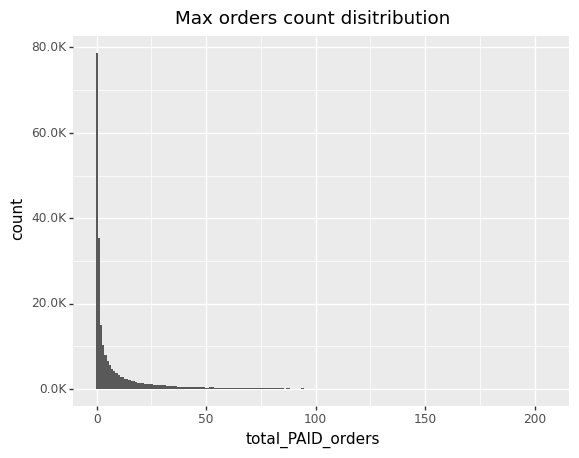

<ggplot: (791007445)>

In [251]:
(
    pn.ggplot(df3[df3.total_PAID_orders<df3.total_PAID_orders.quantile(.99)].reset_index(drop=True)
        , pn.aes(x='total_PAID_orders')) +
    pn.ggtitle('Max orders count disitribution') + 
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
#    pn.scale_x_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.geom_histogram(binwidth=1) #+  # You can adjust the binwidth as needed
    #pn.facet_wrap('~city', scales="free_y", ncol=4) #+
    #pn.theme(figure_size=(15, 20))
    
)

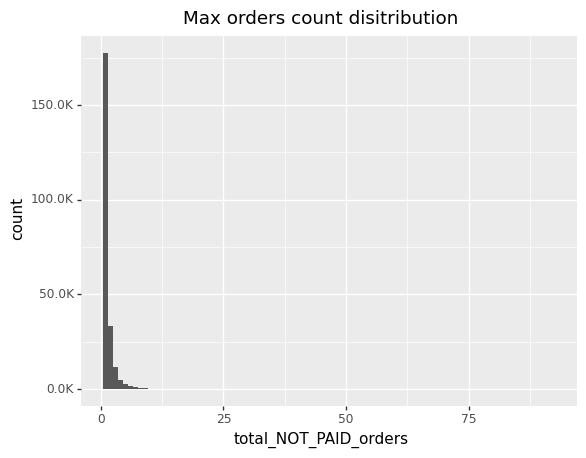

<ggplot: (813755425)>

In [252]:
(
    pn.ggplot(df3
        , pn.aes(x='total_NOT_PAID_orders')) +
    pn.ggtitle('Max orders count disitribution') + 
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
#    pn.scale_x_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.geom_histogram(binwidth=1) #+  # You can adjust the binwidth as needed
    #pn.facet_wrap('~city', scales="free_y", ncol=4) #+
    #pn.theme(figure_size=(15, 20))
    
)

In [253]:
df3

device_id  customer_id  first_network_user_count  \
0         82292700     29080807                         1   
1         47221787     40458304                         2   
2         97672205     21308661                         1   
3        170881293     51572110                         1   
4         19675932     10768307                         2   
...            ...          ...                       ...   
234147   117587655     40105560                         1   
234148    50469921     18424444                         1   
234149  1113556856    133449553                         2   
234150  1009163583    126587736                         2   
234151    66008865     66640039                         2   

        last_network_number_count  total_orders  cusomer_absent_orders  \
0                               2             3                      0   
1                               2            13                      0   
2                               2            13                      0   
3                               2            26                      0   
4                               2             1                      0   
...                           ...           ...                    ...   
234147                          2             4                      0   
234148                          2             7                      0   
234149                          1            47                      0   
234150                          2             1                      0   
234151                          1            84                      0   

               gmv  total_PAID_orders  total_NOT_PAID_orders    PAID_gmv  \
0         7.410285                  1                      2    7.410285   
1       100.069648                 10                      3   72.109353   
2       101.400000                 10                      3   92.400000   
3       172.332858                 25                      1  165.428258   
4         0.000000                  0                      1         NaN   
...            ...                ...                    ...         ...   
234147   14.901552                  2                      2   14.044140   
234148  119.250000                  6                      1  119.250000   
234149  335.149050                 44                      3  304.126770   
234150   21.942960                  0                      1         NaN   
234151  986.800000                 83                      1  973.800000   

        NOT_PAID_gmv  CASH_orders  CREDIT_CARD_orders  PAYPAL_orders  \
0           0.000000            3                   0              0   
1          27.960295           13                   0              0   
2           9.000000           13                   0              0   
3           6.904600           26                   0              0   
4           0.000000            1                   0              0   
...              ...          ...                 ...            ...   
234147      0.857412            4                   0              0   
234148      0.000000            7                   0              0   
234149     31.022280           47                   0              0   
234150     21.942960            1                   0              0   
234151     13.000000           84                   0              0   

        alternative_orders  cash_paid  cash_unpaid  credit_card_paid  \
0                        0          1            2                 0   
1                        0         10            3                 0   
2                        0         10            3                 0   
3                        0         25            1                 0   
4                        0          0            1                 0   
...                    ...        ...          ...               ...   
234147                   0          2            2                 0   
234148                   0       

# TOTAL AGGREGATION

In [254]:
# Sum these columns
pd.DataFrame(df3[df3.columns[4:]].sum()).T

total_orders cusomer_absent_orders              gmv              gmv  \
0      3872595                     0  40266257.292854  40266257.292854   

  total_PAID_orders total_NOT_PAID_orders         PAID_gmv    NOT_PAID_gmv  \
0           3522446                350058  37797382.894213  2467735.048093   

  CASH_orders CREDIT_CARD_orders PAYPAL_orders alternative_orders cash_paid  \
0     3162582             593689         11615             105036   2813625   

  cash_unpaid credit_card_paid credit_card_unpaid PAYPAL_paid PAYPAL_unpaid  \
0      348953           592677               1011       11608             7   

  alternative_paid alternative_unpaid cash_paid_delivered_order  \
0           104860                 87                   2708945   

  cash_NOT_paid_delivered_order cash_NOT_paid_canceled_order  \
0                         24283                       324670   

  credit_card_paid_delivered_order credit_card_NOT_paid_delivered_order  \
0                           539022                                  728   

  credit_card_NOT_paid_canceled_order paypal_paid_delivered_order  \
0                                 283                       10918   

  paypal_NOT_paid_delivered_order paypal_NOT_paid_canceled_order  \
0                               6                              1   

  alternative_paid_delivered_order alternative_NOT_paid_delivered_order  \
0                           100382                                   69   

  alternative_NOT_paid_canceled_order cusomer_absent  \
0                                  18              0   

  marked_paid_cash_customer_absent marked_NOT_paid_cash_customer_absent  \
0                             8408                                80223   

  marked_paid_credit_card_customer_absent  \
0                                    3997   

  marked_NOT_paid_credit_card_customer_absent  \
0                                          29   

  marked_paid_paypal_customer_absent marked_NOT_paid_paypal_customer_absent  \
0                                 80                                      0   

               gmv              gmv              cm         CASH_gmv  \
0  40266257.292854  40266257.292854  2828565.564134  31654292.629852   

          CASH_cm CREDIT_CARD_gmv CREDIT_CARD_cm PAYPAL_gmv    PAYPAL_cm  \
0  2310444.811665  6994914.123126  414384.998745  206198.99  5782.666327   

  alternative_gmv alternative_cm   cash_paid_gmv cash_NOT_paid_gmv  \
0  1410841.859876   97956.568861  29199938.45895    2454280.951765   

     cash_paid_cm cash_NOT_paid_cm credit_card_paid_gmv  \
0  2092636.927579    217826.055926       6982844.898745   

  credit_card_NOT_paid_gmv credit_card_paid_cm credit_card_NOT_paid_cm  \
0             12066.197981       414319.878253               64.722004   

  PAYPAL_paid_gmv PAYPAL_NOT_paid_gmv PAYPAL_paid_cm PAYPAL_NOT_paid_cm  \
0       206007.07              191.92    5767.074555          15.591772   

  alternative_paid_gmv alternative_NOT_paid_gmv alternative_paid_cm  \
0       1408592.466518              1195.978347        98042.022189   

  alternative_NOT_paid_cm cash_paid_delivered_gmv cash_NOT_paid_delivered_gmv  \
0              -75.719747          29164982.96081               376105.651363   

  cash_paid_canceled_gmv cash_NOT_paid_canceled_gmv  \
0            34955.49814             2078175.300402   

  credit_card_paid_delivered_gmv credit_card_NOT_paid_delivered_gmv  \
0                 6902135.483963                       10715.844474   

  credit_card_paid_canceled_gmv credit_card_NOT_paid_canceled_gmv  \
0                  80709.414782                       1350.353507   

  paypal_paid_delivered_gmv paypal_NOT_paid_delivered_gmv  \
0                 204366.77                        161.62   

  paypal_paid_canceled_gmv paypal_NOT_paid_canceled_gmv  \
0                   1640.3                         30.3   

  alternative_paid_delivered_gmv alternative_NOT_paid_delivered_gmv  \
0                 1399281.375309                     

In [255]:
# Sum these columns
pd.DataFrame(df3.query("first_network_user_count== 1 ")[df3.columns[4:]].sum()).T

total_orders cusomer_absent_orders              gmv              gmv  \
0      1629239                     0  16139580.233314  16139580.233314   

  total_PAID_orders total_NOT_PAID_orders         PAID_gmv   NOT_PAID_gmv  \
0           1472910                156257  15193655.723385  944902.503379   

  CASH_orders CREDIT_CARD_orders PAYPAL_orders alternative_orders cash_paid  \
0     1350567             241158          4227              33317   1194883   

  cash_unpaid credit_card_paid credit_card_unpaid PAYPAL_paid PAYPAL_unpaid  \
0      155681           240606                552        4225             2   

  alternative_paid alternative_unpaid cash_paid_delivered_order  \
0            33230                 22                   1152218   

  cash_NOT_paid_delivered_order cash_NOT_paid_canceled_order  \
0                         10461                       145220   

  credit_card_paid_delivered_order credit_card_NOT_paid_delivered_order  \
0                           215278                                  386   

  credit_card_NOT_paid_canceled_order paypal_paid_delivered_order  \
0                                 166                        3967   

  paypal_NOT_paid_delivered_order paypal_NOT_paid_canceled_order  \
0                               2                              0   

  alternative_paid_delivered_order alternative_NOT_paid_delivered_order  \
0                            31755                                   16   

  alternative_NOT_paid_canceled_order cusomer_absent  \
0                                   6              0   

  marked_paid_cash_customer_absent marked_NOT_paid_cash_customer_absent  \
0                             3626                                32441   

  marked_paid_credit_card_customer_absent  \
0                                    1499   

  marked_NOT_paid_credit_card_customer_absent  \
0                                          13   

  marked_paid_paypal_customer_absent marked_NOT_paid_paypal_customer_absent  \
0                                 22                                      0   

               gmv              gmv              cm         CASH_gmv  \
0  16139580.233314  16139580.233314  1127284.665948  12944246.542875   

         CASH_cm CREDIT_CARD_gmv CREDIT_CARD_cm PAYPAL_gmv    PAYPAL_cm  \
0  934887.265622  2705005.801863  162508.936135   73871.74  2482.689219   

  alternative_gmv alternative_cm    cash_paid_gmv cash_NOT_paid_gmv  \
0   416456.148577   27404.931863  12005960.271966     938238.038622   

    cash_paid_cm cash_NOT_paid_cm credit_card_paid_gmv  \
0  855494.705393      79405.49673       2698682.681928   

  credit_card_NOT_paid_gmv credit_card_paid_cm credit_card_NOT_paid_cm  \
0              6323.119934       162446.989606               61.946529   

  PAYPAL_paid_gmv PAYPAL_NOT_paid_gmv PAYPAL_paid_cm PAYPAL_NOT_paid_cm  \
0        73829.72               42.02     2479.18457           3.504649   

  alternative_paid_gmv alternative_NOT_paid_gmv alternative_paid_cm  \
0         415183.04949               299.324823        27421.175237   

  alternative_NOT_paid_cm cash_paid_delivered_gmv cash_NOT_paid_delivered_gmv  \
0              -42.566224         11990875.766176               158051.891557   

  cash_paid_canceled_gmv cash_NOT_paid_canceled_gmv  \
0            15084.50579              780186.147064   

  credit_card_paid_delivered_gmv credit_card_NOT_paid_delivered_gmv  \
0                 2666690.035667                        5631.305323   

  credit_card_paid_canceled_gmv credit_card_NOT_paid_canceled_gmv  \
0                  31992.646262                        691.814612   

  paypal_paid_delivered_gmv paypal_NOT_paid_delivered_gmv  \
0                  73365.37                         42.02   

  paypal_paid_canceled_gmv paypal_NOT_paid_canceled_gmv  \
0                   464.35                          0.0   

  alternative_paid_delivered_gmv alternative_NOT_paid_delivered_gmv  \
0                  412528.992974                         

In [256]:
pd.DataFrame(df3.query("first_network_user_count> 1 ")[df3.columns[4:]].sum()).T

total_orders cusomer_absent_orders             gmv             gmv  \
0      2243356                     0  24126677.05954  24126677.05954   

  total_PAID_orders total_NOT_PAID_orders         PAID_gmv    NOT_PAID_gmv  \
0           2049536                193801  22603727.170828  1522832.544714   

  CASH_orders CREDIT_CARD_orders PAYPAL_orders alternative_orders cash_paid  \
0     1812015             352531          7388              71719   1618742   

  cash_unpaid credit_card_paid credit_card_unpaid PAYPAL_paid PAYPAL_unpaid  \
0      193272           352071                459        7383             5   

  alternative_paid alternative_unpaid cash_paid_delivered_order  \
0            71630                 65                   1556727   

  cash_NOT_paid_delivered_order cash_NOT_paid_canceled_order  \
0                         13822                       179450   

  credit_card_paid_delivered_order credit_card_NOT_paid_delivered_order  \
0                           323744                                  342   

  credit_card_NOT_paid_canceled_order paypal_paid_delivered_order  \
0                                 117                        6951   

  paypal_NOT_paid_delivered_order paypal_NOT_paid_canceled_order  \
0                               4                              1   

  alternative_paid_delivered_order alternative_NOT_paid_delivered_order  \
0                            68627                                   53   

  alternative_NOT_paid_canceled_order cusomer_absent  \
0                                  12              0   

  marked_paid_cash_customer_absent marked_NOT_paid_cash_customer_absent  \
0                             4782                                47782   

  marked_paid_credit_card_customer_absent  \
0                                    2498   

  marked_NOT_paid_credit_card_customer_absent  \
0                                          16   

  marked_paid_paypal_customer_absent marked_NOT_paid_paypal_customer_absent  \
0                                 58                                      0   

              gmv             gmv              cm         CASH_gmv  \
0  24126677.05954  24126677.05954  1701280.898185  18710046.086977   

          CASH_cm CREDIT_CARD_gmv CREDIT_CARD_cm PAYPAL_gmv    PAYPAL_cm  \
0  1375557.546043  4289908.321263  251876.062611  132327.25  3299.977108   

  alternative_gmv alternative_cm    cash_paid_gmv cash_NOT_paid_gmv  \
0   994385.711299   70551.636998  17193978.186984    1516042.913144   

     cash_paid_cm cash_NOT_paid_cm credit_card_paid_gmv  \
0  1237142.222186    138420.559197       4284162.216816   

  credit_card_NOT_paid_gmv credit_card_paid_cm credit_card_NOT_paid_cm  \
0              5743.078047       251872.888648                2.775475   

  PAYPAL_paid_gmv PAYPAL_NOT_paid_gmv PAYPAL_paid_cm PAYPAL_NOT_paid_cm  \
0       132177.35               149.9    3287.889985          12.087123   

  alternative_paid_gmv alternative_NOT_paid_gmv alternative_paid_cm  \
0        993409.417028               896.653523        70620.846952   

  alternative_NOT_paid_cm cash_paid_delivered_gmv cash_NOT_paid_delivered_gmv  \
0              -33.153523         17174107.194634               218053.759806   

  cash_paid_canceled_gmv cash_NOT_paid_canceled_gmv  \
0            19870.99235             1297989.153338   

  credit_card_paid_delivered_gmv credit_card_NOT_paid_delivered_gmv  \
0                 4235445.448296                        5084.539151   

  credit_card_paid_canceled_gmv credit_card_NOT_paid_canceled_gmv  \
0                   48716.76852                        658.538896   

  paypal_paid_delivered_gmv paypal_NOT_paid_delivered_gmv  \
0                  131001.4                         119.6   

  paypal_paid_canceled_gmv paypal_NOT_paid_canceled_gmv  \
0                  1175.95                         30.3   

  alternative_paid_delivered_gmv alternative_NOT_paid_delivered_gmv  \
0                  986752.382335                         78